#input shape and output shape of time series model

* input shape = [ batch_size , window_size ]
* output shape = [ horizon / forecast]

# Get data

We are going to be using historical price data of bitcoin to predict the future price of bitcoin

We get data from coindesk:

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-08-19 05:30:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‚ÄòBTC_USD_2013-10-01_2021-05-18-CoinDesk.csv‚Äô

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-08-19 05:30:28 (7.43 MB/s) - ‚ÄòBTC_USD_2013-10-01_2021-05-18-CoinDesk.csv‚Äô saved [178509/178509]



#importing data with pandas

In [ ]:
import pandas as pd

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                  parse_dates = ["Date"],
                  index_col = ["Date"] # parse date column and tell column 1 is in the datetime forma
                 )
df.head()

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2013-10-01      BTC            123.65499       124.30466       124.75166   
2013-10-02      BTC            125.45500       123.65499       125.75850   
2013-10-03      BTC            108.58483       125.45500       125.66566   
2013-10-04      BTC            118.67466       108.58483       118.67500   
2013-10-05      BTC            121.33866       118.67466       121.93633   

            24h Low (USD)  
Date                       
2013-10-01      122.56349  
2013-10-02      123.63383  
2013-10-03       83.32833  
2013-10-04      107.05816  
2013-10-05      118.00566

In deep learning we need lots and lots of data and in time series problem we may often run into data with smaller data

In [ ]:
df = pd.DataFrame(df["Closing Price (USD)"])
df = df.rename(columns = {"Closing Price (USD)": "prices"})
df.head()

prices
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

#seasonality

* Seasonality of a time series dataset is referred as the number of samples per year.
* for our data we have seasonality / value of 365 as we have one sample per day.

Text(0.5, 1.0, 'Closing price chart')

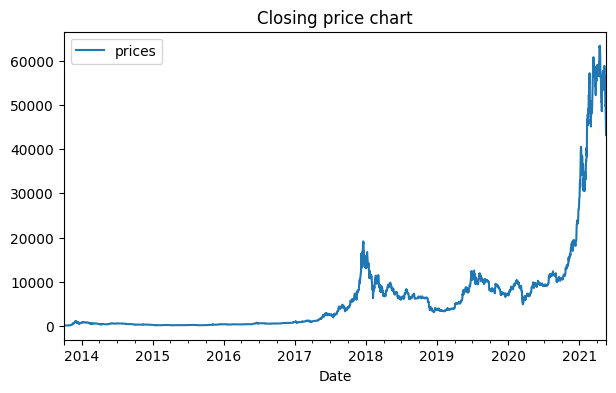

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df.plot(figsize = (7, 4))
plt.title("Closing price chart")

In [ ]:
# import csv
# from datetime import datetime

# timesteps = []
# prices = []

# with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as csv_file:
#   csv_reader = csv.reader(csv_file, delimiter = ",")
#   next(csv_reader)
#   for line in csv_reader:
#     timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
#     prices.append(line[2])

# timesteps[:10], prices[:10]

In [ ]:
# import numpy as np

# plt.figure(figsize = (7,5))
# plt.plot(timesteps, prices)
# plt.xlabel("time")
# plt.ylabel("price")

# plotting isnt as expected and wrong

#NOTE

We arent using train test split feature as it is time series continuous data and we cannot randomly split so we have to do a continuous split and not a discrete/random one.

# Format data part 1: Creating train and test splits

In [ ]:
#making a split for training and testing
split = int(0.8 * len(df))
split

2229

making arrays for timestamp and prices

In [ ]:
timestamp = df.index.to_numpy()
prices = df.prices.to_numpy()
timestamp[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
x_train, y_train = timestamp[:split], prices[:split]
x_test, y_test = timestamp[split:], prices[split:]
len(x_train), len(x_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

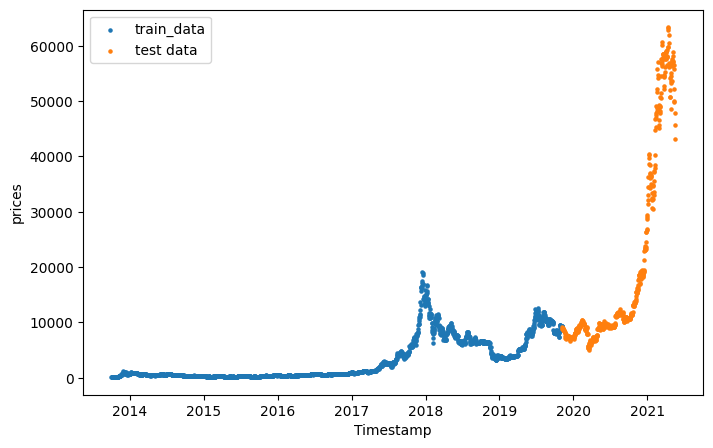

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, s = 5, label = "train_data")
plt.scatter(x_test, y_test, s = 5, label = "test data")
plt.xlabel("Timestamp")
plt.ylabel("prices")
plt.legend()
plt.show()

In [ ]:
def plot_timeseries(timestamp, values, format = ".", start = 0, end = None, label = None):
  """
  Plots the time series data
  """

  plt.plot(timestamp[start:end], values[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)


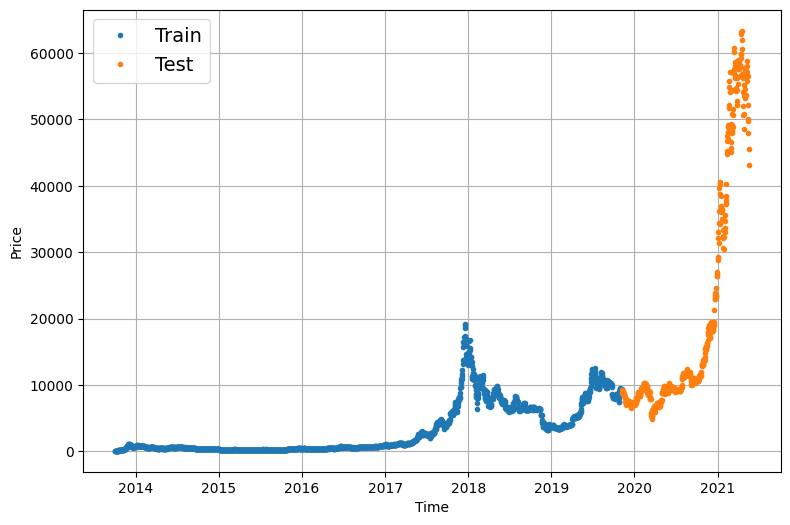

In [ ]:
plt.figure(figsize=(9, 6))
plot_timeseries(x_train, y_train, label = "Train")
plot_timeseries(x_test, y_test, label = "Test")

# Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**.
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Na√Øve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA|
| 10 | Same as 1 (but with turkey ü¶É data introduced) | 1 | 7 | NA |

> üîë **Note:** To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed. )

##important terms

* **Horizon**: Number of timesteps into the future we are going to predict
* **Window Size**: Number of timesteps we are going to use to predict **horizon**

* **NOTE**: further we try to predict the more wrong our prediction may be

#evaluation function to make dictionary of metrics


**The formula is:**
$$\hat{y}_t = y_{t-1}$$

This means the prediction at timestep is is the same as timestep t-1

In [ ]:
import tensorflow as tf

In [ ]:
def mean_abs_scaled_error(y_true, y_pred):
  """
  Calculates the MASE taking true and pred values
  its scaled to naive model
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / mae_naive_no_season


In [ ]:
from tensorflow.keras import metrics

##evaluate preds


In [ ]:

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae = metrics.mean_absolute_error(y_true, y_pred)
  mse = metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_abs_scaled_error(y_true, y_pred)

  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


In [ ]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

# format data part 2 : windowing our dataset

Why?

Coz we want to turn out time series dataset to turn data into supervised machine learning problem

```
Windowing for one week

[1, 2, 3, 4, 5, 6] -> [7]

[2, 3, 4, 5, 6, 7] -> [8]

[3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
# What we want to do with our bitcoin data
print(f"We want to use this {prices[:7]} to predict this {prices[7]}")

We want to use this [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] to predict this 123.033


In [ ]:
HORIZON = 1 #predict next 1 day
WINDOW_SIZE = 7 # use the previous week data to make the prediction

##Get labelled window function

In [ ]:
def get_labelled_window(x, horizon = HORIZON):

  return x[: , :-horizon], x[ : , -horizon:]

In [ ]:
prices[:7], prices[7]

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]),
 123.033)

In [ ]:
sample_window, sample_horizon = get_labelled_window(tf.expand_dims(prices[:8], axis = 0))
print(f"\n{sample_window} -->{sample_horizon}")


[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]] -->[[123.033]]


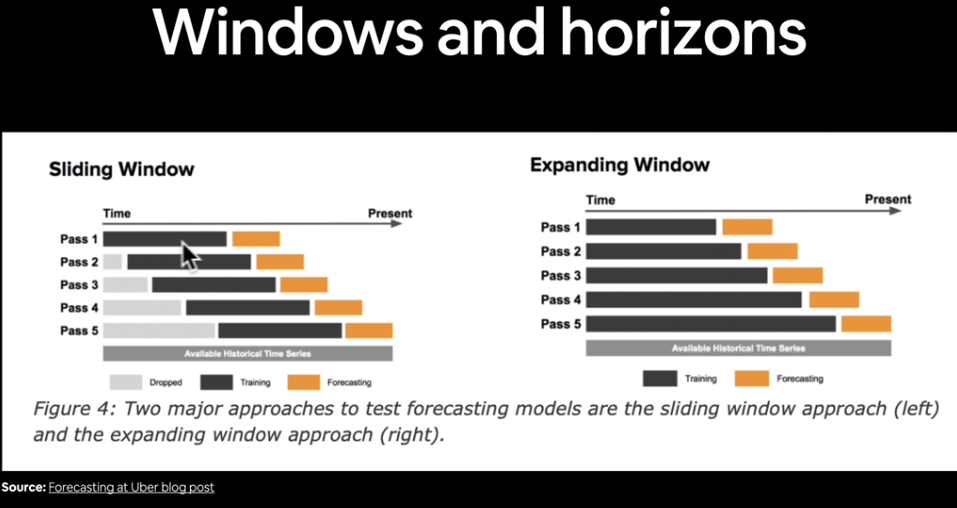

To convert this time series problem into supervised problem we use **HORIZON** and **WINDOW**

the window is the data and the horizon is the label

Now we need to convert our whole data into windows and horizons for our model to train on

We can do this using for loops but that is quite slow so we are using numpys indexing

Oh yeah, that's what I'm talking about!

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> üìñ **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [ ]:
import numpy as np

In [ ]:
np.expand_dims(np.arange(len(prices) - (WINDOW_SIZE + HORIZON -1)) ,axis = 0).T

array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

##Make windows function

In [ ]:
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):

  window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)

  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)) ,axis = 0).T

  windowed_array = prices[window_indexes]

  windows, labels = get_labelled_window(windowed_array, horizon = horizon)
  #print(f"{windows[:10]} \n {labels[:10]}")
  return windows, labels

In [ ]:
final_window, final_label = make_windows(prices)
print(f"window and labels:\n {final_window[0]} --> {final_label[0]}")
print(f"window and labels:\n {final_window[-1]} --> {final_label[-1]}")

window and labels:
 [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> [123.033]
window and labels:
 [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] --> [43144.47129086]


##Making windows using tensorflow function

In [ ]:
#prices[:20]

In [ ]:
#dataset = tf.keras.utils.timeseries_dataset_from_array(data = prices[:-7], sequence_length = 7, targets = prices[7:])
#for batch in dataset:
#  inputs, target = batch
#  print(f"{inputs[0]}\n{target[0]}")

#function for splitting data into training and testing

In [ ]:
def window_horizon_train_test_split(window, horizon, test_size = 0.2):
  """
  takes in window and horizon data and returns training and testing splits
  """

  split_size = int((1-test_size) * len(window))

  train_window = window[:split_size]
  train_label = horizon[:split_size]
  test_window = window[split_size:]
  test_label = horizon[split_size:]

  return train_window, test_window, train_label, test_label

In [ ]:
train_window, test_window, train_label, test_label = window_horizon_train_test_split(final_window, final_label)
len(train_window), len(test_window), len(train_label), len(test_label)

(2224, 556, 2224, 556)

#Make modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment we are going to write modelling checkpoints so as to compare apples to apples.

We want to compare each models best performance against each other.

Example: if our model performs best at epoch 10 and we are training out model for 15 epochs while comparing we want to load and evaluate the model saved on epoch 10

In [ ]:
import os


def create_model_checkpoint(model_name, save_path = "Model_Experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path,model_name),
                                            verbose = 0, #output limited amount of text,
                                            monitor ="val_loss",
                                            save_best_only=True
                                            )

#Creating and training model 1

In [ ]:
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1_dense = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear")
], name = "model_1_dense")

model_1_dense.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

model_1_dense.fit(
    train_window, train_label,
    epochs = 100,
    batch_size = 128,
    validation_data = (test_window, test_label),
    verbose = 1,
    callbacks = [create_model_checkpoint(model_name = model_1_dense.name)]
)

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 2472.8665 - mae: 2472.8665 - mse: 16557199.0000  

18/18 [==============================] - 6s 51ms/step - loss: 2256.1260 - mae: 2256.1260 - mse: 14583968.0000 - val_loss: 2546.1433 - val_mae: 2546.1433 - val_mse: 13888622.0000
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 356.2177 - mae: 356.2177 - mse: 475600.7500

18/18 [==============================] - 1s 33ms/step - loss: 356.2177 - mae: 356.2177 - mse: 475600.7500 - val_loss: 1354.7303 - val_mae: 1354.7303 - val_mse: 4818329.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 173.3016 - mae: 173.3016 - mse: 117506.7031

18/18 [==============================] - 1s 36ms/step - loss: 221.9473 - mae: 221.9473 - mse: 232500.5000 - val_loss: 1000.7916 - val_mae: 1000.7916 - val_mse: 3350971.7500
Epoch 4/100
10/18 [===============>..............] - ETA: 0s - loss: 197.2872 - mae: 197.2872 - mse: 205517.9219

18/18 [==============================] - 1s 61ms/step - loss: 182.5547 - mae: 182.5547 - mse: 173254.7812 - val_loss: 984.3977 - val_mae: 984.3977 - val_mse: 3268255.2500
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 178.9516 - mae: 178.9516 - mse: 168922.9531 - val_loss: 998.5606 - val_mae: 998.5606 - val_mse: 3205802.2500
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 171.8587 - mae: 171.8587 - mse: 149552.9688

18/18 [==============================] - 2s 106ms/step - loss: 173.5430 - mae: 173.5430 - mse: 159487.0000 - val_loss: 962.9073 - val_mae: 962.9073 - val_mse: 3138987.2500
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 174.9233 - mae: 174.9233 - mse: 163252.1094

18/18 [==============================] - 1s 83ms/step - loss: 171.0166 - mae: 171.0166 - mse: 154640.4531 - val_loss: 953.8931 - val_mae: 953.8931 - val_mse: 2954981.0000
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 166.9434 - mae: 166.9434 - mse: 147643.7500

18/18 [==============================] - 1s 67ms/step - loss: 167.1882 - mae: 167.1882 - mse: 148113.9375 - val_loss: 917.0544 - val_mae: 917.0544 - val_mse: 2811443.0000
Epoch 9/100
18/18 [==============================] - 0s 15ms/step - loss: 164.2971 - mae: 164.2971 - mse: 144400.6562 - val_loss: 934.3039 - val_mae: 934.3039 - val_mse: 2767884.5000
Epoch 10/100
10/18 [===============>..............] - ETA: 0s - loss: 156.7376 - mae: 156.7376 - mse: 127794.4375

18/18 [==============================] - 1s 65ms/step - loss: 160.6078 - mae: 160.6078 - mse: 138635.0000 - val_loss: 887.9890 - val_mae: 887.9890 - val_mse: 2589193.5000
Epoch 11/100
10/18 [===============>..............] - ETA: 0s - loss: 157.9866 - mae: 157.9866 - mse: 142179.5781

18/18 [==============================] - 1s 65ms/step - loss: 156.1525 - mae: 156.1525 - mse: 131231.5781 - val_loss: 854.5535 - val_mae: 854.5535 - val_mse: 2462905.7500
Epoch 12/100
18/18 [==============================] - 0s 10ms/step - loss: 152.5406 - mae: 152.5406 - mse: 125397.4531 - val_loss: 909.9868 - val_mae: 909.9868 - val_mse: 2503916.5000
Epoch 13/100
11/18 [=================>............] - ETA: 0s - loss: 143.8946 - mae: 143.8946 - mse: 116836.1328

18/18 [==============================] - 1s 63ms/step - loss: 151.5541 - mae: 151.5541 - mse: 126068.2031 - val_loss: 832.1703 - val_mae: 832.1703 - val_mse: 2258147.2500
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 145.6629 - mae: 145.6629 - mse: 117477.0000

18/18 [==============================] - 1s 60ms/step - loss: 145.8450 - mae: 145.8450 - mse: 116328.8359 - val_loss: 809.1973 - val_mae: 809.1973 - val_mse: 2146633.7500
Epoch 15/100
18/18 [==============================] - 0s 12ms/step - loss: 148.0671 - mae: 148.0671 - mse: 117006.3984 - val_loss: 875.9633 - val_mae: 875.9633 - val_mse: 2262606.7500
Epoch 16/100
 9/18 [==============>...............] - ETA: 0s - loss: 141.5712 - mae: 141.5712 - mse: 105939.0703

18/18 [==============================] - 1s 82ms/step - loss: 143.5818 - mae: 143.5818 - mse: 111693.3750 - val_loss: 760.3237 - val_mae: 760.3237 - val_mse: 1948633.7500
Epoch 17/100
12/18 [===================>..........] - ETA: 0s - loss: 144.1307 - mae: 144.1307 - mse: 112783.0312

18/18 [==============================] - 2s 100ms/step - loss: 138.7666 - mae: 138.7666 - mse: 105822.9141 - val_loss: 752.6456 - val_mae: 752.6456 - val_mse: 1879825.1250
Epoch 18/100
18/18 [==============================] - 0s 15ms/step - loss: 132.8745 - mae: 132.8745 - mse: 98969.5703 - val_loss: 787.4655 - val_mae: 787.4655 - val_mse: 1919625.3750
Epoch 19/100
18/18 [==============================] - 0s 19ms/step - loss: 130.3049 - mae: 130.3049 - mse: 95910.1875 - val_loss: 771.7861 - val_mae: 771.7861 - val_mse: 1849921.1250
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 134.2315 - mae: 134.2315 - mse: 100483.3906

18/18 [==============================] - 2s 112ms/step - loss: 132.4599 - mae: 132.4599 - mse: 98691.5000 - val_loss: 708.6281 - val_mae: 708.6280 - val_mse: 1718397.5000
Epoch 21/100
12/18 [===================>..........] - ETA: 0s - loss: 133.2611 - mae: 133.2611 - mse: 95950.5703 

18/18 [==============================] - 1s 67ms/step - loss: 130.3525 - mae: 130.3525 - mse: 96040.4688 - val_loss: 686.4481 - val_mae: 686.4481 - val_mse: 1619601.2500
Epoch 22/100
11/18 [=================>............] - ETA: 0s - loss: 137.2974 - mae: 137.2974 - mse: 110146.9922

18/18 [==============================] - 1s 60ms/step - loss: 125.7449 - mae: 125.7449 - mse: 90846.9766 - val_loss: 681.6702 - val_mae: 681.6702 - val_mse: 1600534.5000
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 122.0693 - mae: 122.0693 - mse: 83303.2656

18/18 [==============================] - 1s 71ms/step - loss: 123.2086 - mae: 123.2086 - mse: 87875.3516 - val_loss: 669.6418 - val_mae: 669.6418 - val_mse: 1526169.6250
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 122.8999 - mae: 122.8999 - mse: 86712.6562

18/18 [==============================] - 1s 77ms/step - loss: 121.4176 - mae: 121.4176 - mse: 85177.8047 - val_loss: 655.2576 - val_mae: 655.2576 - val_mse: 1490886.5000
Epoch 25/100
18/18 [==============================] - 0s 17ms/step - loss: 120.7805 - mae: 120.7805 - mse: 83338.0000 - val_loss: 657.5963 - val_mae: 657.5963 - val_mse: 1497770.7500
Epoch 26/100
18/18 [==============================] - 0s 21ms/step - loss: 122.8402 - mae: 122.8402 - mse: 83579.1719 - val_loss: 703.7419 - val_mae: 703.7419 - val_mse: 1635422.5000
Epoch 27/100
11/18 [=================>............] - ETA: 0s - loss: 130.9081 - mae: 130.9081 - mse: 95932.0312 

18/18 [==============================] - 1s 55ms/step - loss: 122.9694 - mae: 122.9694 - mse: 85598.3516 - val_loss: 639.2966 - val_mae: 639.2966 - val_mse: 1428521.5000
Epoch 28/100
15/18 [========================>.....] - ETA: 0s - loss: 114.1920 - mae: 114.1920 - mse: 78583.5156

18/18 [==============================] - 1s 65ms/step - loss: 116.1877 - mae: 116.1877 - mse: 79181.8281 - val_loss: 625.9606 - val_mae: 625.9606 - val_mse: 1374763.2500
Epoch 29/100
18/18 [==============================] - 0s 9ms/step - loss: 114.9554 - mae: 114.9554 - mse: 78424.7266 - val_loss: 638.5004 - val_mae: 638.5004 - val_mse: 1380679.5000
Epoch 30/100
12/18 [===================>..........] - ETA: 0s - loss: 117.5211 - mae: 117.5211 - mse: 81461.2734

18/18 [==============================] - 1s 54ms/step - loss: 118.2049 - mae: 118.2049 - mse: 79824.5234 - val_loss: 615.8739 - val_mae: 615.8739 - val_mse: 1342729.0000
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 114.1168 - mae: 114.1168 - mse: 76308.4219 - val_loss: 656.3690 - val_mae: 656.3690 - val_mse: 1409422.3750
Epoch 32/100
11/18 [=================>............] - ETA: 0s - loss: 116.9109 - mae: 116.9109 - mse: 77004.5312

18/18 [==============================] - 1s 65ms/step - loss: 115.2622 - mae: 115.2622 - mse: 79256.9141 - val_loss: 610.5712 - val_mae: 610.5712 - val_mse: 1312807.5000
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 114.0724 - mae: 114.0724 - mse: 77173.1562 - val_loss: 646.1406 - val_mae: 646.1406 - val_mse: 1377491.0000
Epoch 34/100
14/18 [======================>.......] - ETA: 0s - loss: 117.2040 - mae: 117.2040 - mse: 84566.5703 

18/18 [==============================] - 2s 92ms/step - loss: 114.6364 - mae: 114.6364 - mse: 77876.1406 - val_loss: 600.8374 - val_mae: 600.8374 - val_mse: 1287049.0000
Epoch 35/100
13/18 [====================>.........] - ETA: 0s - loss: 116.3935 - mae: 116.3935 - mse: 82244.1719

18/18 [==============================] - 1s 47ms/step - loss: 112.8312 - mae: 112.8312 - mse: 77026.8594 - val_loss: 597.9103 - val_mae: 597.9103 - val_mse: 1283744.0000
Epoch 36/100
18/18 [==============================] - 0s 8ms/step - loss: 119.0066 - mae: 119.0066 - mse: 78109.0391 - val_loss: 602.3710 - val_mae: 602.3710 - val_mse: 1275675.8750
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 116.2104 - mae: 116.2104 - mse: 79269.4375 - val_loss: 608.0410 - val_mae: 608.0410 - val_mse: 1300093.1250
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 105.1222 - mae: 105.1222 - mse: 70740.0312

18/18 [==============================] - 1s 32ms/step - loss: 112.5834 - mae: 112.5834 - mse: 75893.7578 - val_loss: 591.8837 - val_mae: 591.8837 - val_mse: 1257063.1250
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7237 - mae: 112.7237 - mse: 75132.2656 - val_loss: 620.5930 - val_mae: 620.5930 - val_mse: 1323202.5000
Epoch 40/100
17/18 [===========================>..] - ETA: 0s - loss: 111.5909 - mae: 111.5909 - mse: 75631.1328 

18/18 [==============================] - 1s 30ms/step - loss: 111.2265 - mae: 111.2265 - mse: 75022.2266 - val_loss: 587.4443 - val_mae: 587.4443 - val_mse: 1245979.1250
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1458 - mae: 114.1458 - mse: 75668.3203 - val_loss: 703.1327 - val_mae: 703.1327 - val_mse: 1540401.0000
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 120.1519 - mae: 120.1519 - mse: 79694.9766 - val_loss: 596.1597 - val_mae: 596.1597 - val_mse: 1262626.2500
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3235 - mae: 111.3235 - mse: 74355.9375 - val_loss: 609.2986 - val_mae: 609.2986 - val_mse: 1287421.3750
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 68.1356 - mae: 68.1356 - mse: 18611.5391

18/18 [==============================] - 1s 31ms/step - loss: 113.7259 - mae: 113.7259 - mse: 75423.3750 - val_loss: 583.1397 - val_mae: 583.1397 - val_mse: 1231828.5000
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 81.9963 - mae: 81.9963 - mse: 38300.6484

18/18 [==============================] - 1s 47ms/step - loss: 109.6584 - mae: 109.6584 - mse: 73855.1172 - val_loss: 583.1309 - val_mae: 583.1309 - val_mse: 1231155.0000
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 83.8503 - mae: 83.8503 - mse: 49270.0625

18/18 [==============================] - 1s 32ms/step - loss: 111.1247 - mae: 111.1247 - mse: 73237.4219 - val_loss: 581.2404 - val_mae: 581.2404 - val_mse: 1225200.1250
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 114.0518 - mae: 114.0518 - mse: 76557.0078 - val_loss: 638.6066 - val_mae: 638.6066 - val_mse: 1332123.8750
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 109.3595 - mae: 109.3595 - mse: 66232.7891

18/18 [==============================] - 1s 31ms/step - loss: 110.3869 - mae: 110.3869 - mse: 73784.9766 - val_loss: 578.9411 - val_mae: 578.9411 - val_mse: 1216656.7500
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2612 - mae: 110.2612 - mse: 73655.4844 - val_loss: 641.1954 - val_mae: 641.1954 - val_mse: 1335985.8750
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 117.0647 - mae: 117.0647 - mse: 76513.9766 - val_loss: 587.6697 - val_mae: 587.6697 - val_mse: 1223789.8750
Epoch 51/100
16/18 [=========================>....] - ETA: 0s - loss: 109.3112 - mae: 109.3112 - mse: 73249.5703

18/18 [==============================] - 1s 33ms/step - loss: 109.4422 - mae: 109.4422 - mse: 72388.2812 - val_loss: 577.2867 - val_mae: 577.2867 - val_mse: 1210124.0000
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 118.2736 - mae: 118.2736 - mse: 68188.8594

18/18 [==============================] - 1s 30ms/step - loss: 110.5525 - mae: 110.5525 - mse: 74428.2344 - val_loss: 576.6870 - val_mae: 576.6870 - val_mse: 1209290.7500
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9374 - mae: 113.9374 - mse: 75431.7656 - val_loss: 616.0839 - val_mae: 616.0839 - val_mse: 1276430.5000
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7973 - mae: 115.7973 - mse: 75830.2266 - val_loss: 629.5588 - val_mae: 629.5588 - val_mse: 1305445.7500
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9074 - mae: 111.9074 - mse: 74662.9844 - val_loss: 577.2809 - val_mae: 577.2809 - val_mse: 1208356.6250
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5877 - mae: 108.5877 - mse: 72104.6953 - val_loss: 743.1267 - val_mae: 743.1267 - val_mse: 1644685.6250
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 123.9657 - mae: 123.9657 - m

18/18 [==============================] - 1s 31ms/step - loss: 110.7358 - mae: 110.7358 - mse: 72697.4375 - val_loss: 570.8542 - val_mae: 570.8542 - val_mse: 1187006.1250
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4747 - mae: 109.4747 - mse: 71552.6953 - val_loss: 583.3309 - val_mae: 583.3309 - val_mse: 1201694.6250
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 109.0845 - mae: 109.0845 - mse: 71882.9922 - val_loss: 613.9584 - val_mae: 613.9584 - val_mse: 1272192.2500
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8793 - mae: 117.8793 - mse: 72645.4844 - val_loss: 698.4087 - val_mae: 698.4087 - val_mse: 1491472.1250
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 123.3072 - mae: 123.3072 - mse: 80548.4844 - val_loss: 605.0126 - val_mae: 605.0126 - val_mse: 1251166.8750
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 126.8529 - mae: 126.8529 - m

18/18 [==============================] - 1s 33ms/step - loss: 107.5730 - mae: 107.5730 - mse: 71171.1875 - val_loss: 569.2650 - val_mae: 569.2650 - val_mse: 1179887.7500
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6185 - mae: 107.6185 - mse: 70834.9609 - val_loss: 580.8687 - val_mae: 580.8687 - val_mse: 1192172.8750
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 77.8168 - mae: 77.8168 - mse: 27323.5098

18/18 [==============================] - 1s 30ms/step - loss: 108.9881 - mae: 108.9881 - mse: 71449.2109 - val_loss: 567.0814 - val_mae: 567.0814 - val_mse: 1171847.8750
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 107.2598 - mae: 107.2598 - mse: 69675.2344 - val_loss: 575.8852 - val_mae: 575.8852 - val_mse: 1188345.7500
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8637 - mae: 108.8637 - mse: 70254.5938 - val_loss: 575.2476 - val_mae: 575.2476 - val_mse: 1187344.7500
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5256 - mae: 109.5256 - mse: 73784.5703 - val_loss: 606.8002 - val_mae: 606.8002 - val_mse: 1249910.7500
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1182 - mae: 108.1182 - mse: 71406.0469 - val_loss: 583.2909 - val_mae: 583.2909 - val_mse: 1194062.5000
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 107.7780 - mae: 107.7780 - m

##function for making predictions

In [ ]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #to remove extra dimension which is not needed

#Loading and evaluation best model

In [ ]:
model_1_dense.evaluate(test_window, test_label)

18/18 [==============================] - 0s 2ms/step - loss: 631.9736 - mae: 631.9736 - mse: 1290071.7500


[631.9736328125, 631.9736328125, 1290071.75]

In [ ]:
model_1_dense = tf.keras.models.load_model("Model_Experiments/model_1_dense/")
model_1_dense.evaluate(test_window, test_label)

18/18 [==============================] - 0s 2ms/step - loss: 567.0815 - mae: 567.0815 - mse: 1171848.5000


[567.08154296875, 567.08154296875, 1171848.5]

In [ ]:
model_1_preds = make_preds(model_1_dense, test_window)
model_1_preds.shape

18/18 [==============================] - 0s 1ms/step


TensorShape([556])

In [ ]:
test_label.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

##results of model 1

In [ ]:
model_1_res = evaluate_preds(tf.squeeze(test_label), model_1_preds)
model_1_res

{'mae': 567.0816,
 'mse': 1171848.5,
 'rmse': 1082.5195,
 'mape': 2.5444036,
 'mase': 0.028189559}

##Plotting result

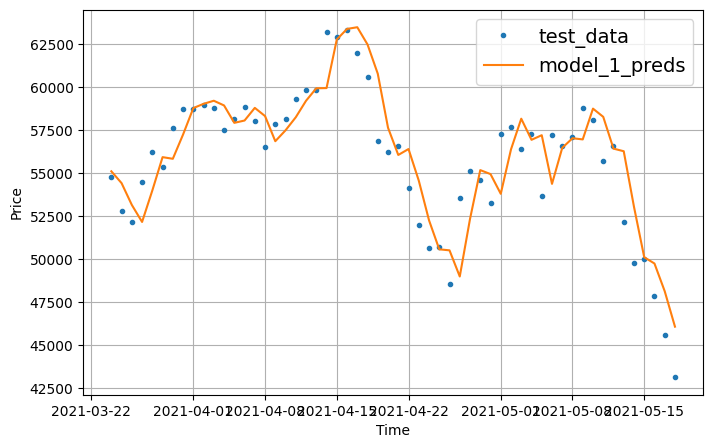

In [ ]:
plt.figure(figsize = (8,5))
offset = 500
plot_timeseries(
    x_test[-len(test_window):],
    values = test_label[:, 0],
    start = offset,
    label = "test_data"
)

plot_timeseries(
    x_test[-len(test_window):],
    values = model_1_preds,
    start = offset,
    label = "model_1_preds",
    format = "-"
)

#Note Autocorrelation

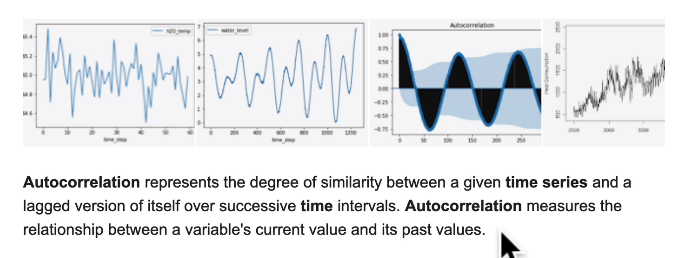

as we can see above the model preds are slightly lagging when comapred to test data and this is because of **AutoCorrelation**

#Building model 2 with window_size = 30 and horizon = 1

##making windows and horizons

In [ ]:
window_2, label_2 = make_windows(prices, 30, 1)
window_2[:3], label_2[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

##train test split

In [ ]:
train_window_2, test_window_2, train_label_2, test_label_2 = window_horizon_train_test_split(window_2, label_2)
len(train_window_2), len(test_window_2), len(train_label_2), len(test_label_2)

(2205, 552, 2205, 552)

##training model 2

In [ ]:
from tensorflow.keras import layers

tf.random.set_seed(42)

model_2_dense = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear")
], name = "model_2_dense")

model_2_dense.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

model_2_dense.fit(
    train_window_2, train_label_2,
    epochs = 100,
    batch_size = 128,
    validation_data = (test_window_2, test_label_2),
    verbose = 1,
    callbacks = [create_model_checkpoint(model_name = model_2_dense.name)]
)

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 522.6829 - mae: 522.6829 - mse: 1145489.2500   

18/18 [==============================] - 2s 42ms/step - loss: 504.1623 - mae: 504.1623 - mse: 1088858.6250 - val_loss: 1863.9717 - val_mae: 1863.9717 - val_mse: 9157686.0000
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 228.4383 - mae: 228.4383 - mse: 268212.1250

18/18 [==============================] - 1s 33ms/step - loss: 227.8524 - mae: 227.8524 - mse: 266759.5000 - val_loss: 1298.4581 - val_mae: 1298.4581 - val_mse: 5354358.0000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 203.9083 - mae: 203.9083 - mse: 209496.7969

18/18 [==============================] - 1s 33ms/step - loss: 203.7788 - mae: 203.7788 - mse: 208417.5000 - val_loss: 975.3414 - val_mae: 975.3414 - val_mse: 3278058.7500
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 199.1986 - mae: 199.1986 - mse: 194531.6719

18/18 [==============================] - 1s 33ms/step - loss: 199.1986 - mae: 199.1986 - mse: 194531.6719 - val_loss: 877.3660 - val_mae: 877.3660 - val_mse: 2726904.5000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 187.0281 - mae: 187.0281 - mse: 170062.7344 - val_loss: 993.7244 - val_mae: 993.7244 - val_mse: 2893241.5000
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 161.0976 - mae: 161.0976 - mse: 140293.7812 - val_loss: 911.3203 - val_mae: 911.3203 - val_mse: 2574942.2500
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 151.9104 - mae: 151.9104 - mse: 127911.2969 - val_loss: 1241.7040 - val_mae: 1241.7040 - val_mse: 4458602.5000
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 162.7724 - mae: 162.7724 - mse: 140426.9531 - val_loss: 966.3649 - val_mae: 966.3649 - val_mse: 3059934.2500
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 153.1215 - mae: 153.1215 - mse

18/18 [==============================] - 1s 47ms/step - loss: 153.1215 - mae: 153.1215 - mse: 122912.9453 - val_loss: 831.9829 - val_mae: 831.9829 - val_mse: 2225726.5000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 174.3889 - mae: 174.3889 - mse: 147886.0312

18/18 [==============================] - 1s 34ms/step - loss: 154.2545 - mae: 154.2545 - mse: 120810.6328 - val_loss: 776.6832 - val_mae: 776.6832 - val_mse: 2100660.7500
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 152.4803 - mae: 152.4803 - mse: 122421.0859 - val_loss: 894.2645 - val_mae: 894.2645 - val_mse: 2376612.7500
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 156.4349 - mae: 156.4349 - mse: 119622.7812 - val_loss: 957.7840 - val_mae: 957.7840 - val_mse: 2938760.7500
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 168.4617 - mae: 168.4617 - mse: 113914.7188

18/18 [==============================] - 1s 31ms/step - loss: 158.6391 - mae: 158.6391 - mse: 125440.7266 - val_loss: 746.5715 - val_mae: 746.5715 - val_mse: 1984224.5000
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 164.8500 - mae: 164.8500 - mse: 127549.7344 - val_loss: 1055.9639 - val_mae: 1055.9639 - val_mse: 2934085.7500
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 151.8216 - mae: 151.8216 - mse: 114066.8203 - val_loss: 757.6079 - val_mae: 757.6079 - val_mse: 2030327.0000
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 161.5885 - mae: 161.5885 - mse: 127072.5391 - val_loss: 774.1252 - val_mae: 774.1252 - val_mse: 1952366.6250
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 145.6008 - mae: 145.6008 - mse: 109295.0859 - val_loss: 749.3068 - val_mae: 749.3068 - val_mse: 1870179.0000
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 150.8539 - mae: 150.8

18/18 [==============================] - 1s 31ms/step - loss: 142.7202 - mae: 142.7202 - mse: 105785.4297 - val_loss: 721.3931 - val_mae: 721.3931 - val_mse: 1797754.3750
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 139.3311 - mae: 139.3311 - mse: 90841.0938

18/18 [==============================] - 1s 31ms/step - loss: 132.9298 - mae: 132.9298 - mse: 96970.6953 - val_loss: 700.1796 - val_mae: 700.1796 - val_mse: 1675069.6250
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 109.3164 - mae: 109.3164 - mse: 52375.7734

18/18 [==============================] - 1s 31ms/step - loss: 125.2907 - mae: 125.2907 - mse: 89041.9609 - val_loss: 692.6820 - val_mae: 692.6820 - val_mse: 1689701.3750
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 102.9625 - mae: 102.9625 - mse: 38908.4453

18/18 [==============================] - 1s 43ms/step - loss: 130.8717 - mae: 130.8717 - mse: 94201.2969 - val_loss: 684.0500 - val_mae: 684.0500 - val_mse: 1656389.2500
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 133.7908 - mae: 133.7908 - mse: 97015.2109 - val_loss: 756.2579 - val_mae: 756.2579 - val_mse: 1905018.6250
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 134.8563 - mae: 134.8563 - mse: 99552.6016 - val_loss: 1610.4109 - val_mae: 1610.4109 - val_mse: 5564466.5000
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 173.8900 - mae: 173.8900 - mse: 127243.7266 - val_loss: 1030.3254 - val_mae: 1030.3254 - val_mse: 2737784.0000
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 136.9336 - mae: 136.9336 - mse: 97013.5625 - val_loss: 844.5739 - val_mae: 844.5739 - val_mse: 2246727.0000
Epoch 32/100
18/18 [==============================] - 0s 7ms/step - loss: 150.3971 - mae: 150.397

18/18 [==============================] - 1s 45ms/step - loss: 145.0965 - mae: 145.0965 - mse: 98531.2109 - val_loss: 664.0268 - val_mae: 664.0268 - val_mse: 1555214.2500
Epoch 34/100
14/18 [======================>.......] - ETA: 0s - loss: 122.6181 - mae: 122.6181 - mse: 84237.0781

18/18 [==============================] - 1s 34ms/step - loss: 123.2177 - mae: 123.2177 - mse: 85849.3281 - val_loss: 662.3822 - val_mae: 662.3822 - val_mse: 1541700.8750
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 124.8586 - mae: 124.8586 - mse: 86074.5000 - val_loss: 761.2938 - val_mae: 761.2938 - val_mse: 1792056.8750
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 126.0459 - mae: 126.0459 - mse: 89295.7578 - val_loss: 756.7755 - val_mae: 756.7755 - val_mse: 1892848.1250
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 125.7794 - mae: 125.7794 - mse: 89399.6250 - val_loss: 676.6600 - val_mae: 676.6600 - val_mse: 1545503.2500
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 135.9522 - mae: 135.9522 - mse: 73355.2969

18/18 [==============================] - 1s 31ms/step - loss: 122.8906 - mae: 122.8906 - mse: 85552.0938 - val_loss: 650.1794 - val_mae: 650.1794 - val_mse: 1500143.2500
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 129.8325 - mae: 129.8325 - mse: 87645.8438 - val_loss: 774.0007 - val_mae: 774.0007 - val_mse: 1895191.5000
Epoch 40/100
15/18 [========================>.....] - ETA: 0s - loss: 130.9740 - mae: 130.9740 - mse: 92264.6094

18/18 [==============================] - 1s 33ms/step - loss: 131.0961 - mae: 131.0961 - mse: 90204.9141 - val_loss: 638.8775 - val_mae: 638.8775 - val_mse: 1428549.6250
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 119.3328 - mae: 119.3328 - mse: 80647.6953 - val_loss: 886.0445 - val_mae: 886.0445 - val_mse: 2139334.5000
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 139.6012 - mae: 139.6012 - mse: 95764.4297 - val_loss: 705.7017 - val_mae: 705.7017 - val_mse: 1698739.5000
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 121.7150 - mae: 121.7150 - mse: 84535.8047 - val_loss: 729.5004 - val_mae: 729.5004 - val_mse: 1736887.0000
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 150.2504 - mae: 150.2504 - mse: 108368.6406 - val_loss: 715.1150 - val_mae: 715.1150 - val_mse: 1614920.6250
Epoch 45/100
18/18 [==============================] - 0s 7ms/step - loss: 120.5929 - mae: 120.5929 - 

18/18 [==============================] - 1s 33ms/step - loss: 130.4198 - mae: 130.4198 - mse: 88569.4297 - val_loss: 629.9216 - val_mae: 629.9216 - val_mse: 1404652.0000
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 128.0329 - mae: 128.0329 - mse: 84791.4531 - val_loss: 722.7348 - val_mae: 722.7348 - val_mse: 1704684.5000
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 182.3930 - mae: 182.3930 - mse: 130899.5078 - val_loss: 778.7254 - val_mae: 778.7254 - val_mse: 1853633.6250
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 126.5565 - mae: 126.5565 - mse: 83288.8438 - val_loss: 652.6255 - val_mae: 652.6255 - val_mse: 1450136.7500
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 131.5871 - mae: 131.5871 - mse: 85761.6953

18/18 [==============================] - 1s 31ms/step - loss: 124.0991 - mae: 124.0991 - mse: 81902.7422 - val_loss: 621.1030 - val_mae: 621.1030 - val_mse: 1355137.8750
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 119.7452 - mae: 119.7452 - mse: 78733.6250 - val_loss: 823.6688 - val_mae: 823.6688 - val_mse: 2015194.6250
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 151.5231 - mae: 151.5231 - mse: 105850.0859 - val_loss: 1268.6857 - val_mae: 1268.6857 - val_mse: 3657134.5000
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 194.7637 - mae: 194.7637 - mse: 144847.0469 - val_loss: 675.4387 - val_mae: 675.4387 - val_mse: 1542735.5000
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 168.5742 - mae: 168.5742 - mse: 122653.6641 - val_loss: 749.0378 - val_mae: 749.0378 - val_mse: 1683798.0000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 130.4500 - mae: 130.450

18/18 [==============================] - 1s 31ms/step - loss: 126.6771 - mae: 126.6771 - mse: 80317.5000 - val_loss: 618.4283 - val_mae: 618.4283 - val_mse: 1349150.8750
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 120.7175 - mae: 120.7175 - mse: 78602.9453 - val_loss: 652.6721 - val_mae: 652.6721 - val_mse: 1453348.8750
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 132.5607 - mae: 132.5607 - mse: 88042.9922 - val_loss: 744.5797 - val_mae: 744.5797 - val_mse: 1742106.8750
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 119.9608 - mae: 119.9608 - mse: 78407.4766 - val_loss: 702.7746 - val_mae: 702.7746 - val_mse: 1536759.6250
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 115.8556 - mae: 115.8556 - mse: 73886.6484 - val_loss: 627.6658 - val_mae: 627.6658 - val_mse: 1346485.6250
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 124.6820 - mae: 124.6820 - m

18/18 [==============================] - 1s 31ms/step - loss: 117.8920 - mae: 117.8920 - mse: 74843.7969 - val_loss: 601.7402 - val_mae: 601.7402 - val_mse: 1271693.6250
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1682 - mae: 114.1682 - mse: 73030.6094 - val_loss: 623.9302 - val_mae: 623.9302 - val_mse: 1314665.0000
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 114.7872 - mae: 114.7872 - mse: 76337.2891 - val_loss: 820.0895 - val_mae: 820.0895 - val_mse: 1977654.5000
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 120.7190 - mae: 120.7190 - mse: 77413.6406 - val_loss: 849.3341 - val_mae: 849.3341 - val_mse: 2058986.6250
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 128.3670 - mae: 128.3670 - mse: 84175.0312 - val_loss: 708.8232 - val_mae: 708.8232 - val_mse: 1532367.7500
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 126.4025 - mae: 126.4025 - m

18/18 [==============================] - 1s 31ms/step - loss: 118.1766 - mae: 118.1766 - mse: 75126.2031 - val_loss: 594.7840 - val_mae: 594.7840 - val_mse: 1260872.6250
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3784 - mae: 112.3784 - mse: 71202.4844 - val_loss: 695.0533 - val_mae: 695.0533 - val_mse: 1494174.6250
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 143.4026 - mae: 143.4026 - mse: 90670.5703 - val_loss: 717.6096 - val_mae: 717.6096 - val_mse: 1597753.7500
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 136.2931 - mae: 136.2931 - mse: 126933.6016

18/18 [==============================] - 1s 46ms/step - loss: 139.4928 - mae: 139.4928 - mse: 87910.4062 - val_loss: 594.4124 - val_mae: 594.4124 - val_mse: 1249615.2500
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 132.8723 - mae: 132.8723 - mse: 84860.8516 - val_loss: 623.3425 - val_mae: 623.3425 - val_mse: 1305600.0000
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 134.3517 - mae: 134.3517 - mse: 87653.3750 - val_loss: 604.1066 - val_mae: 604.1066 - val_mse: 1300944.6250
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 122.5954 - mae: 122.5954 - mse: 77849.7969 - val_loss: 598.2782 - val_mae: 598.2782 - val_mse: 1259259.2500
Epoch 91/100
18/18 [==============================] - 0s 11ms/step - loss: 113.4318 - mae: 113.4318 - mse: 70950.8516 - val_loss: 717.7781 - val_mae: 717.7781 - val_mse: 1605419.2500
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 120.2769 - mae: 120.2769 - 

18/18 [==============================] - 1s 46ms/step - loss: 114.0504 - mae: 114.0504 - mse: 72908.8125 - val_loss: 591.8210 - val_mae: 591.8210 - val_mse: 1236577.1250
Epoch 95/100
18/18 [==============================] - 0s 8ms/step - loss: 136.1416 - mae: 136.1416 - mse: 83885.7578 - val_loss: 963.0905 - val_mae: 963.0905 - val_mse: 2489964.7500
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 140.9906 - mae: 140.9906 - mse: 87581.7891 - val_loss: 1264.0182 - val_mae: 1264.0182 - val_mse: 3609531.0000
Epoch 97/100
18/18 [==============================] - 0s 10ms/step - loss: 166.9502 - mae: 166.9502 - mse: 116768.0547 - val_loss: 633.5269 - val_mae: 633.5269 - val_mse: 1321437.7500
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 119.9525 - mae: 119.9525 - mse: 75340.2422 - val_loss: 964.0612 - val_mae: 964.0612 - val_mse: 2339006.2500
Epoch 99/100
18/18 [==============================] - 0s 7ms/step - loss: 142.2187 - mae: 142.2187

18/18 [==============================] - 1s 33ms/step - loss: 116.0772 - mae: 116.0772 - mse: 72889.7734 - val_loss: 591.4622 - val_mae: 591.4622 - val_mse: 1231148.1250


In [ ]:
model_2_dense.evaluate(test_window_2, test_label_2)

18/18 [==============================] - 0s 2ms/step - loss: 591.4621 - mae: 591.4621 - mse: 1231147.7500


[591.4620971679688, 591.4620971679688, 1231147.75]

In [ ]:
model_2_dense = tf.keras.models.load_model(
    "/content/Model_Experiments/model_2_dense"
)

model_2_dense.evaluate(test_window_2, test_label_2)

18/18 [==============================] - 0s 2ms/step - loss: 591.4621 - mae: 591.4621 - mse: 1231147.7500


[591.4620971679688, 591.4620971679688, 1231147.75]

In [ ]:
model_2_preds = make_preds(model_2_dense, test_window_2)
model_2_preds.shape

18/18 [==============================] - 0s 1ms/step


TensorShape([552])

##model 2 results

In [ ]:
model_2_res = evaluate_preds(tf.squeeze(test_label_2), model_2_preds)
model_2_res

{'mae': 591.4621,
 'mse': 1231147.6,
 'rmse': 1109.5709,
 'mape': 2.6369185,
 'mase': 0.0292822}

#Model 3 using window size = 30, horizon = 7

##making windows and horizons

In [ ]:
window_3, label_3 = make_windows(prices, window_size = 30, horizon = 7)
window_3[:3], label_3[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

##making train_test_splits

In [ ]:
train_window_3, test_window_3, train_label_3, test_label_3 = window_horizon_train_test_split(window_3, label_3)
len(train_window_3), len(test_window_3), len(train_label_3), len(test_label_3)
test_label_3[:5]

array([[8794.35864452, 8798.04205463, 9081.18687849, 8711.53433917,
        8760.89271814, 8749.52059102, 8656.97092235],
       [8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
        8749.52059102, 8656.97092235, 8500.64355816],
       [9081.18687849, 8711.53433917, 8760.89271814, 8749.52059102,
        8656.97092235, 8500.64355816, 8469.2608989 ],
       [8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 , 8537.33965197],
       [8760.89271814, 8749.52059102, 8656.97092235, 8500.64355816,
        8469.2608989 , 8537.33965197, 8205.80636599]])

In [ ]:
tf.random.set_seed(42)
HORIZON = 7
model_3_dense = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3_dense.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

model_3_dense.fit(
    train_window_3, train_label_3,
    epochs = 100,
    batch_size = 128,
    validation_data = (test_window_3, test_label_3),
    verbose = 0,
    callbacks = [create_model_checkpoint(model_name = model_3_dense.name)]
)

In [ ]:
model_3_dense.evaluate(test_window_3, test_label_3)

18/18 [==============================] - 0s 2ms/step - loss: 1403.6874 - mae: 1403.6874 - mse: 6107469.0000


[1403.6873779296875, 1403.6873779296875, 6107469.0]

In [ ]:
model_3_dense = tf.keras.models.load_model("/content/Model_Experiments/model_3_dense")
model_3_dense.evaluate(test_window_3, test_label_3)

18/18 [==============================] - 0s 3ms/step - loss: 1250.7452 - mae: 1250.7452 - mse: 5388820.5000


[1250.7452392578125, 1250.7452392578125, 5388820.5]

In [ ]:
model_3_preds = make_preds(model_3_dense ,test_window_3)
model_3_preds[:3]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[9436.145, 9343.208, 9338.596, 9228.309, 9245.496, 9210.927,
        9451.093],
       [9098.951, 8884.069, 9080.499, 8974.32 , 8766.797, 8993.679,
        9179.987],
       [8691.221, 8839.051, 8741.968, 8932.641, 8704.708, 8878.302,
        9167.521]], dtype=float32)>

#Updating evaluate preds function

 to make it work on different horizons

Reduce dimensionality of the data to visualize it in a simple and better way

In [ ]:

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae = metrics.mean_absolute_error(y_true, y_pred)
  mse = metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_abs_scaled_error(y_true, y_pred)

  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


##model 3 results

In [ ]:
model_3_res = evaluate_preds(tf.squeeze(test_label_3), model_3_preds)
model_3_res

{'mae': 1250.7451,
 'mse': 5388820.5,
 'rmse': 1440.2556,
 'mape': 5.5489864,
 'mase': 0.062497176}

##model 3 preds

In [ ]:
model_3_preds[:2],model_3_preds[:2, 0],model_3_preds[:2, 1]

(<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
 array([[9436.145, 9343.208, 9338.596, 9228.309, 9245.496, 9210.927,
         9451.093],
        [9098.951, 8884.069, 9080.499, 8974.32 , 8766.797, 8993.679,
         9179.987]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([9436.145, 9098.951], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([9343.208, 8884.069], dtype=float32)>)

##plotting preds and true target values

In [ ]:
model_3_preds.shape

TensorShape([551, 7])

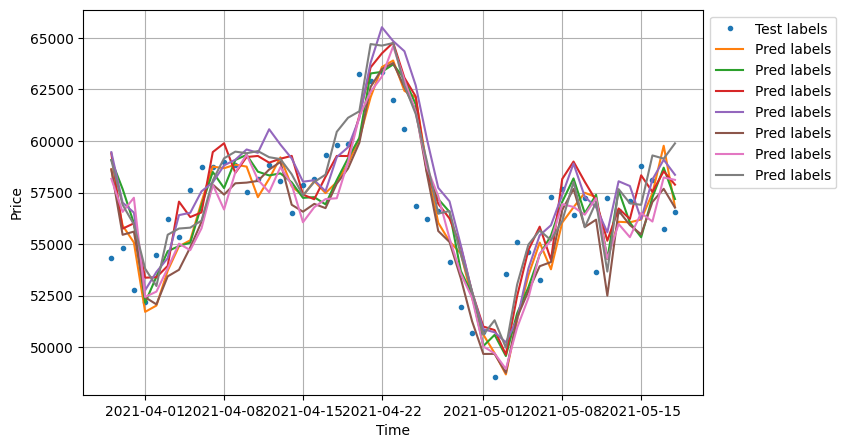

In [ ]:
offset = 500

plt.figure(figsize = (8, 5))
ax = plt.subplot(111)
plot_timeseries(
    x_test[-len(test_window_3):],
    test_label_3[:,0],
    start = offset,
    label = "Test labels"
)

plot_timeseries(
    x_test[-len(test_window_3):],
    model_3_preds[:,:],
    start = offset,
    label = "Pred labels",
    format = "-"
)
ax.legend(bbox_to_anchor = (1.0, 1.0))

plt.show()


#Making results dictionary until model 3

In [ ]:
import pandas as pd

models_until_3 = pd.DataFrame({
    "window_size_7": model_1_res,
    "window_size_30": model_2_res,
    "window_size_30_horizon_7":model_3_res
})

models_until_3 = models_until_3.transpose()
models_until_3

mae          mse         rmse      mape  \
window_size_7              567.081604  1171848.500  1082.519531  2.544404   
window_size_30             591.462097  1231147.625  1109.570923  2.636919   
window_size_30_horizon_7  1250.745117  5388820.500  1440.255615  5.548986   

                              mase  
window_size_7             0.028190  
window_size_30            0.029282  
window_size_30_horizon_7  0.062497

##plotting dictionary

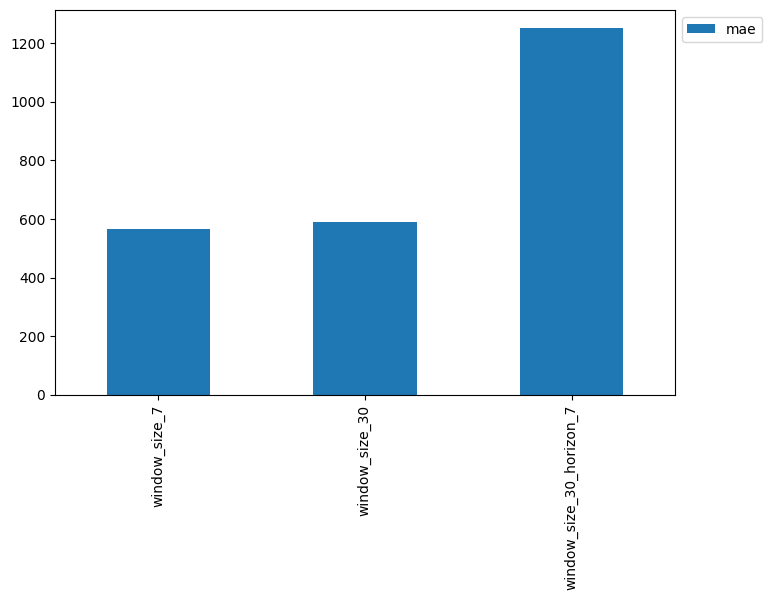

In [ ]:
models_until_3["mae"].plot(kind = "bar", figsize = (8,5)).legend(bbox_to_anchor = (1.0, 1.0))

#Model 4 conv1d

##Creating dataset

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

#windows_4, label_4 = make_windows(prices, WINDOW_SIZE, HORIZON)
#window_4[:2], label_4[:2]

train_window.shape, train_label.shape, test_window.shape, test_label.shape

((2224, 7), (2224, 1), (556, 7), (556, 1))

In [ ]:
sample_tensor = tf.constant(train_window[0])
sample_tensor

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

##expand dims function with layers.lambda

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))

In [ ]:
print(f"original shape: {sample_tensor.shape}")
print(f"expanded layer: {expand_dims_layer(sample_tensor).shape}")
print(f"expanded layer:\n{expand_dims_layer(sample_tensor)}")

original shape: (7,)
expanded layer: (7, 1)
expanded layer:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


##making and training model 4

In [ ]:
tf.random.set_seed(8)

model_4_conv1d = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
    layers.Conv1D(filters = 512, kernel_size = 5, padding = "causal", activation = "relu"),
    layers.Dense(HORIZON)
], name = "conv_1d_7_1")

model_4_conv1d.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
)

history_4 = model_4_conv1d.fit(
    train_window, train_label,
    epochs = 150,
    batch_size = 128,
    validation_data = (test_window, test_label),
    verbose = 0,
    callbacks = [create_model_checkpoint(model_4_conv1d.name)]
)

##loading and evaluating best model

In [ ]:
model_4_conv1d.evaluate(test_window, test_label)

18/18 [==============================] - 0s 4ms/step - loss: 583.6260


583.6260375976562

In [ ]:
model_4_conv1d = tf.keras.models.load_model("/content/Model_Experiments/conv_1d_7_1")
model_4_conv1d.evaluate(test_window, test_label)

18/18 [==============================] - 0s 2ms/step - loss: 564.8080


564.8079833984375

In [ ]:
model_4_preds = make_preds(model_4_conv1d, test_window)
model_4_preds.shape

18/18 [==============================] - 0s 2ms/step


TensorShape([556])

##model 4 results

In [ ]:
model_4_res = evaluate_preds(
    tf.squeeze(test_label, axis = 1),
    model_4_preds
)

model_4_res

{'mae': 564.8079,
 'mse': 1159276.5,
 'rmse': 1076.697,
 'mape': 2.510585,
 'mase': 0.028076535}

In [ ]:
models_until_3

mae          mse         rmse      mape  \
window_size_7              567.081604  1171848.500  1082.519531  2.544404   
window_size_30             591.462097  1231147.625  1109.570923  2.636919   
window_size_30_horizon_7  1250.745117  5388820.500  1440.255615  5.548986   

                              mase  
window_size_7             0.028190  
window_size_30            0.029282  
window_size_30_horizon_7  0.062497

#model 5 lstm

##making and training

In [ ]:

tf.random.set_seed(8)

inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))(inputs)
x = layers.LSTM(128, activation = "relu", recurrent_activation = "tanh")(x)
outputs = layers.Dense(HORIZON)(x)

model_5_lstm = tf.keras.Model(inputs, outputs, name = "lstm_7_1")

model_5_lstm.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
)

model_5_lstm.fit(
    train_window, train_label,
    epochs = 150,
    batch_size = 128,
    validation_data = (test_window, test_label),
    verbose = 1,
    callbacks = [create_model_checkpoint(model_5_lstm.name)]
)

Epoch 1/150
18/18 [==============================] - 4s 137ms/step - loss: 2207.4907 - val_loss: 7977.9873
Epoch 2/150
18/18 [==============================] - 2s 131ms/step - loss: 617.0112 - val_loss: 1850.5902
Epoch 3/150
18/18 [==============================] - 2s 122ms/step - loss: 264.0178 - val_loss: 1471.1545
Epoch 4/150
18/18 [==============================] - 2s 104ms/step - loss: 209.8248 - val_loss: 1130.9231
Epoch 5/150
18/18 [==============================] - 2s 105ms/step - loss: 200.2868 - val_loss: 1109.6326
Epoch 6/150
18/18 [==============================] - 2s 102ms/step - loss: 197.7242 - val_loss: 1105.8984
Epoch 7/150
18/18 [==============================] - 0s 8ms/step - loss: 195.8804 - val_loss: 1134.7777
Epoch 8/150
18/18 [==============================] - 2s 106ms/step - loss: 193.4258 - val_loss: 1087.2988
Epoch 9/150
18/18 [==============================] - 3s 169ms/step - loss: 193.3767 - val_loss: 1080.8944
Epoch 10/150
18/18 [===========================

##evaluating model 5

In [ ]:
model_5_lstm.evaluate(test_window, test_label)

18/18 [==============================] - 0s 2ms/step - loss: 590.0314


590.0314331054688

In [ ]:
model_5_lstm = tf.keras.models.load_model("/content/Model_Experiments/lstm_7_1")
model_5_lstm.evaluate(test_window, test_label)

18/18 [==============================] - 0s 2ms/step - loss: 567.1653


567.165283203125

In [ ]:
model_5_preds = make_preds(model_5_lstm, test_window)
model_5_preds[:7]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([8900.823, 8802.786, 9018.627, 8823.422, 8772.395, 8743.173,
       8697.19 ], dtype=float32)>

In [ ]:
model_5_results = evaluate_preds(
    tf.squeeze(test_label, axis = 1),
    model_5_preds
)
model_5_results

{'mae': 567.16534,
 'mse': 1174806.6,
 'rmse': 1083.885,
 'mape': 2.5617263,
 'mase': 0.028193722}

#Feature Engineering

We can use bitcoin halving events as price tends to increase after the halving of block reward

In [ ]:
reward_1 = 50
reward_2 = 25
reward_3 = 12.5
reward_4 = 6.25

reward_2_datetime = np.datetime64("2012-11-28")
reward_3_datetime = np.datetime64("2016-07-09")
reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
#df.index[0]

In [ ]:
reward_3_days = (reward_3_datetime - df.index[0]).days
reward_4_days = (reward_4_datetime - df.index[0]).days

reward_3_days, reward_4_days

(1012, 2421)

In [ ]:
block_rew_df = df
block_rew_df["block_reward"]  = None
block_rew_df[:7]

prices block_reward
Date                              
2013-10-01  123.65499         None
2013-10-02  125.45500         None
2013-10-03  108.58483         None
2013-10-04  118.67466         None
2013-10-05  121.33866         None
2013-10-06  120.65533         None
2013-10-07  121.79500         None

In [ ]:
block_rew_df.iloc[:reward_3_days, -1] = reward_2
block_rew_df.iloc[reward_3_days:reward_4_days, -1] = reward_3
block_rew_df.iloc[reward_4_days:, -1] = reward_4

block_rew_df.head()

prices block_reward
Date                              
2013-10-01  123.65499           25
2013-10-02  125.45500           25
2013-10-03  108.58483           25
2013-10-04  118.67466           25
2013-10-05  121.33866           25

In [ ]:
block_rew_df.block_reward.value_counts()

12.50    1409
25.00    1012
6.25      366
Name: block_reward, dtype: int64

<Axes: xlabel='Date'>

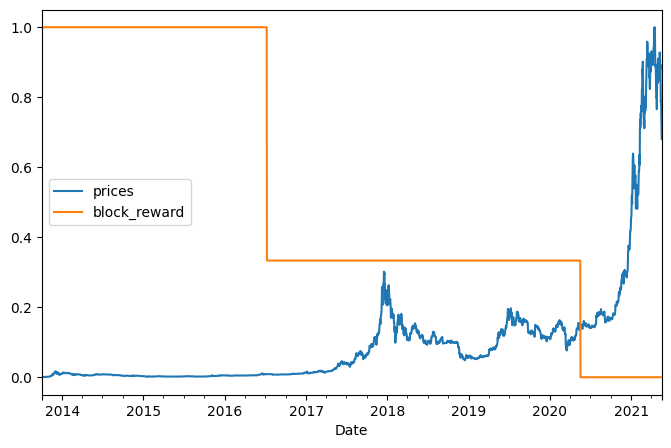

In [ ]:
from sklearn.preprocessing import minmax_scale

scaled_block_df = pd.DataFrame(minmax_scale(
    block_rew_df[["prices", "block_reward"]]),
    columns = block_rew_df.columns,
    index = block_rew_df.index)

scaled_block_df.plot(figsize = (8,5))

##Making windowed dataset using pandas

our function works with only univariate data we are using shift method in pandas to shift the data

In [ ]:
WINDOW_SIZE , HORIZON

(7, 1)

In [ ]:
windowed_block_df = block_rew_df.rename(columns = {"prices":"price"}).copy()

for i in range(WINDOW_SIZE):
  windowed_block_df[f"price {i+1}"] = windowed_block_df["price"].shift(i+1)

windowed_block_df.head(10)

price block_reward    price 1    price 2    price 3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   
2013-10-06  120.65533           25  121.33866  118.67466  108.58483   
2013-10-07  121.79500           25  120.65533  121.33866  118.67466   
2013-10-08  123.03300           25  121.79500  120.65533  121.33866   
2013-10-09  124.04900           25  123.03300  121.79500  120.65533   
2013-10-10  125.96116           25  124.04900  123.03300  121.79500   

              price 4    price 5    price 6    price 7  
Date                                                    
2013-10-01        NaN        NaN        NaN        NaN  
2013-10-02        NaN        NaN        NaN        NaN  
2013-10-03        NaN        NaN        NaN        NaN  
2013-10-04        NaN        NaN        NaN        NaN  
2013-10-05  123.65499        NaN        NaN        NaN  
2013-10-06  125.45500  123.65499        NaN        NaN  
2013-10-07  108.58483  125.45500  123.65499        NaN  
2013-10-08  118.67466  108.58483  125.45500  123.65499  
2013-10-09  121.33866  118.67466  108.58483  125.45500  
2013-10-10  120.65533  121.33866  118.67466  108.58483

In [ ]:
windowed_block_df.head(10)

price block_reward    price 1    price 2    price 3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   
2013-10-06  120.65533           25  121.33866  118.67466  108.58483   
2013-10-07  121.79500           25  120.65533  121.33866  118.67466   
2013-10-08  123.03300           25  121.79500  120.65533  121.33866   
2013-10-09  124.04900           25  123.03300  121.79500  120.65533   
2013-10-10  125.96116           25  124.04900  123.03300  121.79500   

              price 4    price 5    price 6    price 7  
Date                                                    
2013-10-01        NaN        NaN        NaN        NaN  
2013-10-02        NaN        NaN        NaN        NaN  
2013-10-03        NaN        NaN        NaN        NaN  
2013-10-04        NaN        NaN        NaN        NaN  
2013-10-05  123.65499        NaN        NaN        NaN  
2013-10-06  125.45500  123.65499        NaN        NaN  
2013-10-07  108.58483  125.45500  123.65499        NaN  
2013-10-08  118.67466  108.58483  125.45500  123.65499  
2013-10-09  121.33866  118.67466  108.58483  125.45500  
2013-10-10  120.65533  121.33866  118.67466  108.58483

##splitting into train and test datasets

In [ ]:
x = windowed_block_df.dropna().drop("price", axis = 1).astype(np.float32)
y = windowed_block_df.dropna()["price"].astype(np.float32)
x.head(), y.head()

(            block_reward     price 1     price 2     price 3     price 4  \
 Date                                                                       
 2013-10-08          25.0  121.794998  120.655327  121.338661  118.674660   
 2013-10-09          25.0  123.032997  121.794998  120.655327  121.338661   
 2013-10-10          25.0  124.049004  123.032997  121.794998  120.655327   
 2013-10-11          25.0  125.961159  124.049004  123.032997  121.794998   
 2013-10-12          25.0  125.279663  125.961159  124.049004  123.032997   
 
                price 5     price 6     price 7  
 Date                                            
 2013-10-08  108.584831  125.455002  123.654991  
 2013-10-09  118.674660  108.584831  125.455002  
 2013-10-10  121.338661  118.674660  108.584831  
 2013-10-11  120.655327  121.338661  118.674660  
 2013-10-12  121.794998  120.655327  121.338661  ,
 Date
 2013-10-08    123.032997
 2013-10-09    124.049004
 2013-10-10    125.961159
 2013-10-11    125.27966

In [ ]:
split_s = int(len(x) * 0.8)

x_train ,x_test= x[:split_s], x[split_s:]
y_train, y_test = y[:split_s], y[split_s:]

len(x_train) ,len(x_test), len(y_train), len(y_test)
y_test[-1]

43144.473

##creating and trianing model 6

In [ ]:
tf.random.set_seed(8)

model_6_mv = tf.keras.Sequential([
    layers.Dense(64, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "multivariate_7_1")

model_6_mv.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
)

model_6_mv.fit(
    x_train, y_train,
    epochs = 100,
    batch_size = 128,
    validation_data = (x_test, y_test),
    verbose = 1,
    callbacks = [create_model_checkpoint(model_6_mv.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 20s - loss: 3379.6663

18/18 [==============================] - 2s 44ms/step - loss: 1432.9554 - val_loss: 3707.1768
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 653.1719

18/18 [==============================] - 1s 37ms/step - loss: 326.7720 - val_loss: 1456.3256
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 339.5068

18/18 [==============================] - 1s 36ms/step - loss: 236.0368 - val_loss: 1129.8853
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 195.7991

18/18 [==============================] - 1s 37ms/step - loss: 197.0090 - val_loss: 1096.8002
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 220.4080

18/18 [==============================] - 1s 73ms/step - loss: 181.1783 - val_loss: 1026.9111
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 174.7533

18/18 [==============================] - 1s 54ms/step - loss: 167.4742 - val_loss: 882.9788
Epoch 7/100
13/18 [====================>.........] - ETA: 0s - loss: 150.5676

18/18 [==============================] - 1s 52ms/step - loss: 154.1136 - val_loss: 821.4892
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 152.0977 - val_loss: 836.8536
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 146.8347 - val_loss: 903.8815
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 144.0787

18/18 [==============================] - 1s 38ms/step - loss: 144.0787 - val_loss: 737.7278
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 131.0447

18/18 [==============================] - 1s 37ms/step - loss: 140.1356 - val_loss: 713.9893
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 127.6755

18/18 [==============================] - 1s 36ms/step - loss: 137.6868 - val_loss: 710.4437
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 106.9987

18/18 [==============================] - 1s 36ms/step - loss: 142.5115 - val_loss: 694.7899
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 135.9061

18/18 [==============================] - 1s 37ms/step - loss: 135.9061 - val_loss: 683.5518
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 142.5942 - val_loss: 966.2799
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 147.5410

18/18 [==============================] - 1s 37ms/step - loss: 147.2452 - val_loss: 680.6348
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 112.3794

18/18 [==============================] - 1s 37ms/step - loss: 134.7578 - val_loss: 679.0900
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 133.1858

18/18 [==============================] - 1s 37ms/step - loss: 129.6467 - val_loss: 658.7958
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 134.0644 - val_loss: 669.3555
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 130.0579

18/18 [==============================] - 1s 36ms/step - loss: 129.4822 - val_loss: 639.9695
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 157.7997

18/18 [==============================] - 1s 35ms/step - loss: 120.8746 - val_loss: 638.4720
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 120.5924

18/18 [==============================] - 1s 59ms/step - loss: 120.5924 - val_loss: 631.2538
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 126.0851

18/18 [==============================] - 1s 37ms/step - loss: 119.5607 - val_loss: 629.2898
Epoch 24/100
16/18 [=========================>....] - ETA: 0s - loss: 123.2786

18/18 [==============================] - 1s 37ms/step - loss: 121.7644 - val_loss: 620.0508
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1270 - val_loss: 648.4847
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 117.2299

18/18 [==============================] - 1s 38ms/step - loss: 116.6554 - val_loss: 610.9348
Epoch 27/100
18/18 [==============================] - 0s 8ms/step - loss: 114.8141 - val_loss: 663.7040
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 123.8700 - val_loss: 611.3671
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 125.3805 - val_loss: 619.2615
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2087 - val_loss: 691.6614
Epoch 31/100
14/18 [======================>.......] - ETA: 0s - loss: 119.3356

18/18 [==============================] - 1s 57ms/step - loss: 120.4477 - val_loss: 596.3358
Epoch 32/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2311 - val_loss: 711.5369
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 124.6072 - val_loss: 695.8228
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 116.5398

18/18 [==============================] - 1s 43ms/step - loss: 114.8435 - val_loss: 591.6302
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 113.3943

18/18 [==============================] - 1s 36ms/step - loss: 113.3943 - val_loss: 582.6729
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9919 - val_loss: 663.5037
Epoch 37/100
18/18 [==============================] - 0s 4ms/step - loss: 123.1519 - val_loss: 638.6651
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 115.3223 - val_loss: 583.9698
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6996 - val_loss: 648.6630
Epoch 40/100
17/18 [===========================>..] - ETA: 0s - loss: 112.9404

18/18 [==============================] - 1s 37ms/step - loss: 111.7989 - val_loss: 575.2196
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2738 - val_loss: 607.9240
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8244 - val_loss: 610.5296
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 116.0910 - val_loss: 593.8029
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1216 - val_loss: 718.9702
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 114.2833 - val_loss: 606.5613
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2717 - val_loss: 608.9279
Epoch 47/100
15/18 [========================>.....] - ETA: 0s - loss: 104.9447

18/18 [==============================] - 1s 37ms/step - loss: 106.5422 - val_loss: 564.2158
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 124.2707

18/18 [==============================] - 1s 37ms/step - loss: 107.5148 - val_loss: 562.0470
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2350 - val_loss: 604.0034
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 117.6955 - val_loss: 763.5706
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 125.0287 - val_loss: 566.8686
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5253 - val_loss: 654.7756
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 118.8630 - val_loss: 622.3945
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8202 - val_loss: 568.0910
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2856 - val_loss: 754.0678
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3565 - val_loss: 572.9343
Epoch 57/100
18/18 [==============================] - ETA: 0s - loss: 109.05

18/18 [==============================] - 1s 37ms/step - loss: 109.0552 - val_loss: 561.0302
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 112.7726 - val_loss: 836.6216
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 123.1285 - val_loss: 596.7084
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 108.6454 - val_loss: 672.5144
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3722 - val_loss: 568.8523
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 108.5360 - val_loss: 568.7266
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 118.5876 - val_loss: 636.9736
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0549 - val_loss: 574.5387
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 106.0425 - val_loss: 624.1184
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 11

18/18 [==============================] - 1s 37ms/step - loss: 107.4257 - val_loss: 560.6492
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 108.7857 - val_loss: 697.2103
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5444 - val_loss: 564.3635
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 107.0609 - val_loss: 578.7036
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4318 - val_loss: 562.8752
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 123.2614 - val_loss: 611.6915
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7668 - val_loss: 577.2007
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 106.3842 - val_loss: 612.4941
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 105.5849 - val_loss: 562.3226
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 10

In [ ]:
model_6_mv.evaluate(x_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 582.0726


582.0726318359375

In [ ]:
model_6_mv = tf.keras.models.load_model("/content/Model_Experiments/multivariate_7_1")
model_6_mv.evaluate(x_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 560.6490


560.6490478515625

In [ ]:
model_6_preds = model_6_mv.predict(x_test)
model_6_preds[-1]

18/18 [==============================] - 0s 2ms/step


array([46054.523], dtype=float32)

In [ ]:
model_6_res = evaluate_preds(
    y_test,
    model_6_preds
)
model_6_res

{'mae': 17145.71,
 'mse': 614864600.0,
 'rmse': 23717.967,
 'mape': 113.32252,
 'mase': 0.85231125}

In [ ]:
models_until_3

mae          mse         rmse      mape  \
window_size_7              567.081604  1171848.500  1082.519531  2.544404   
window_size_30             591.462097  1231147.625  1109.570923  2.636919   
window_size_30_horizon_7  1250.745117  5388820.500  1440.255615  5.548986   

                              mase  
window_size_7             0.028190  
window_size_30            0.029282  
window_size_30_horizon_7  0.062497

## Model 7: N-BEATS algorithm

Time to step things up a notch.

So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

We're not going to go through all of the details in the paper, instead we're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Doing this will give us an opportunity to practice:
* Creating a custom layer for the `NBeatsBlock` by subclassing [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
  * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
* Implementing a custom architecture using the Functional API
* Finding a paper related to our problem and seeing how it goes

> üîë **Note:** As you'll see in the paper, the authors state ‚ÄúN-BEATS is implemented and trained in TensorFlow‚Äù, that's what we'll be doing too!


##NBeats Block Layer

In [ ]:
class NBeatsblock(tf.keras.layers.Layer):
  def __init__(
      self,
      input_size: int,
      theta_size: int,
      horizon: int,
      n_neurons: int, #how hidden units are in a layer
      n_layers: int, # how many layers are in the stack
      **kwargs
  ):

    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    #Block contains 4 fully connected layers(dense layers) and each has relu activation

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation = "relu") for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation = "linear", name = "theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

When neural networks get initialized they get started with random weights so we set random seed to get reproducability


In [ ]:
tf.random.set_seed(8)

dummy_nbeats_layer = NBeatsblock(
    input_size = WINDOW_SIZE,
    theta_size = WINDOW_SIZE + HORIZON,
    horizon = HORIZON,
    n_neurons = 128,
    n_layers = 4
)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis = 0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats_layer(dummy_inputs)
#these are activation outputs theta layer (they are random as we did not train out model yet)
print(f"Backcast: {tf.squeeze(backcast).numpy()}\nForecast:{tf.squeeze(forecast).numpy()}")

Backcast: [-0.46345615  0.22105524  0.5871168  -0.20797896  0.337741   -0.29232842
  0.04431278]
Forecast:0.02941223978996277


##tf.data apt

we will now use tf.data api for better performance as it has better input pipelining i.e to make input data load as fast as possible.

https://www.tensorflow.org/guide/data_performance

In [ ]:
#create N-BEATS data inputs  (N-Beats works with univariate time series data)

prices_df = df.drop("block_reward", axis = 1).rename(columns = {"prices":"price"})
prices_df.head(7)

price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866
2013-10-06  120.65533
2013-10-07  121.79500

In [ ]:
prices_nbeats_df = prices_df.copy()

for i in range(WINDOW_SIZE):
  prices_nbeats_df[f"price {1 + i}"] = prices_df["price"].shift(periods = i+1)

prices_nbeats_df.head(10)

price    price 1    price 2    price 3    price 4    price 5  \
Date                                                                           
2013-10-01  123.65499        NaN        NaN        NaN        NaN        NaN   
2013-10-02  125.45500  123.65499        NaN        NaN        NaN        NaN   
2013-10-03  108.58483  125.45500  123.65499        NaN        NaN        NaN   
2013-10-04  118.67466  108.58483  125.45500  123.65499        NaN        NaN   
2013-10-05  121.33866  118.67466  108.58483  125.45500  123.65499        NaN   
2013-10-06  120.65533  121.33866  118.67466  108.58483  125.45500  123.65499   
2013-10-07  121.79500  120.65533  121.33866  118.67466  108.58483  125.45500   
2013-10-08  123.03300  121.79500  120.65533  121.33866  118.67466  108.58483   
2013-10-09  124.04900  123.03300  121.79500  120.65533  121.33866  118.67466   
2013-10-10  125.96116  124.04900  123.03300  121.79500  120.65533  121.33866   

              price 6    price 7  
Date                              
2013-10-01        NaN        NaN  
2013-10-02        NaN        NaN  
2013-10-03        NaN        NaN  
2013-10-04        NaN        NaN  
2013-10-05        NaN        NaN  
2013-10-06        NaN        NaN  
2013-10-07  123.65499        NaN  
2013-10-08  125.45500  123.65499  
2013-10-09  108.58483  125.45500  
2013-10-10  118.67466  108.58483

In [ ]:
x = prices_nbeats_df.dropna().drop("price", axis = 1)
y = prices_nbeats_df.dropna()["price"]

split_s = int(0.8 * len(x))

x_train, y_train = x[:split_s], y[:split_s]
x_test, y_test = x[split_s:], y[split_s:]

len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_target_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_target_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_target_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_target_dataset))

batch_size = 1024

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

##NOTE

in most papers the hyperparameters are mostly in capital case.

*  **WIDTH = NO OF NEURONS**
*  **DEPTH = NO OF LAYERS**


In [ ]:
#Values from n-beats paper

N_EPOCHS = 5000 #ITERATIONS IN PAPER
N_NEURONS = 512 #WIDTH
N_LAYERS = 4 #IN THE FIGURE IN STACK THERE ARE 4 LAYERS
N_STACKS = 30 #STACKS

#BLOCKS COMBINED TOGETHER TO CREATE STACKS AND STACKS ARE COMBINED TOGETHER TO CREATE OVERALL MODEL
#THEY USED ENSEMBLES OF MODELS TO CREATE THE MODEL (ALSO USED DIFFERENT WINDOW_SIZES FOR DIFFERENT INTERIOR MODELS TO CREATE OVERALL MODEL)
#WE ARE GOING TO STICK WITH 7

INPUT_SIZE = WINDOW_SIZE * HORIZON #LOOPBACK PERIOD
THETA_SIZE  = INPUT_SIZE + HORIZON

INPUT_SIZE , THETA_SIZE


(7, 8)

#residual connections (section 3.2 in the paper)
i.e adding and subtracting layers output...layers.add, layers.subtract

Residual stacking: adds inputs of the stack of layers to the outputs before passing them to the next stack.

These approach provides clear advantages in improving the trainability of the deep architectures.

##There are two main reasons to add skip connections:
* They avoid the problem of vanishing gradients
It means that if there are a lot of layers by the time the outputs reach the last layers they become so small and they NN cannot be trained as the values do not reach the end.

###See the other point in wikipedia or chatgpt

In [ ]:
tensor1 = tf.range(10) + 10
tensor2 = tf.range(10)

add = layers.add([tensor1, tensor2])
sub = layers.subtract([tensor1, tensor2])

print(f"tensor_1:{tensor1}\ntensor_2:{tensor2}\nadd: {add}\nsubtract: {sub}")

tensor_1:[10 11 12 13 14 15 16 17 18 19]
tensor_2:[0 1 2 3 4 5 6 7 8 9]
add: [10 12 14 16 18 20 22 24 26 28]
subtract: [10 10 10 10 10 10 10 10 10 10]


### Building, compiling and fitting the N-BEATS algorithm

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

Woah. A bunch of steps. But I'm sure you're up to it.

Let's do it!

#NOTE:

backcast must be subtracted from original backcast and forecast must be added together

In [ ]:
# %%time

# tf.random.set_seed(8)

# #setup an instance of NBeats block

# nbeats_block_layer = NBeatsblock(
#     input_size = INPUT_SIZE,
#     theta_size = THETA_SIZE,
#     horizon = HORIZON,
#     n_neurons = N_NEURONS,
#     n_layers = N_LAYERS,
#     name = "Initial_Block"
# )

# #create input stack
# stack_input = layers.Input(shape = INPUT_SIZE, name = "stack_input")

# #create initial backcast and forecast (window_size + horizon)
# residuals, forecast = nbeats_block_layer(stack_input)

# #create stacks of block layers
# for i, _ in enumerate(range(N_STACKS-1)):

#   #USE NBEATS BLOCK TO CALCULATE BACKCAST AND FORECAST
#   backcast, block_forecast = nbeats_block_layer = NBeatsblock(
#     input_size = INPUT_SIZE,
#     theta_size = THETA_SIZE,
#     horizon = HORIZON,
#     n_neurons = N_NEURONS,
#     n_layers = N_LAYERS,
#     name = f"nbeats_block_{i}"
# )(residuals) # pass in the residuals


#   #create the double residual stacking
#   residuals = layers.subtract([residuals, backcast], name = f"subtract_{i}")
#   forecast = layers.add([forecast,block_forecast], name = f"add_{i}")

#   #put stack model together

# model_7_nb = tf.keras.Model(inputs = stack_input, outputs = forecast, name = "model_7_nbeats")

# model_7_nb.compile(
#       loss = "mae",
#       optimizer=tf.keras.optimizers.Adam()
#   )

# model_7_nb.fit(
#     train_dataset,
#     epochs = N_EPOCHS,
#     validation_data = test_dataset,
#     verbose = 0,
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
#                                          patience = 200,
#                                          restore_best_weights = True
#                                          ),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor = "val_loss",
#             patience = 100,
#             verbose = 1
#             )
#     ]

# )

##Plotting the model

This is the same diagram as in the paper. Although it may not look pretty it is the same as in diagram.

In [ ]:
#from tensorflow.keras.utils import plot_model

#plot_model(model_7_nb)

#Model 8: Ensemble

(Stacking different models together)

```Ensemble methods use multiple learning algorithms to obtain better predictive performance than that could be obtained from constituent learning algorithms alone.```

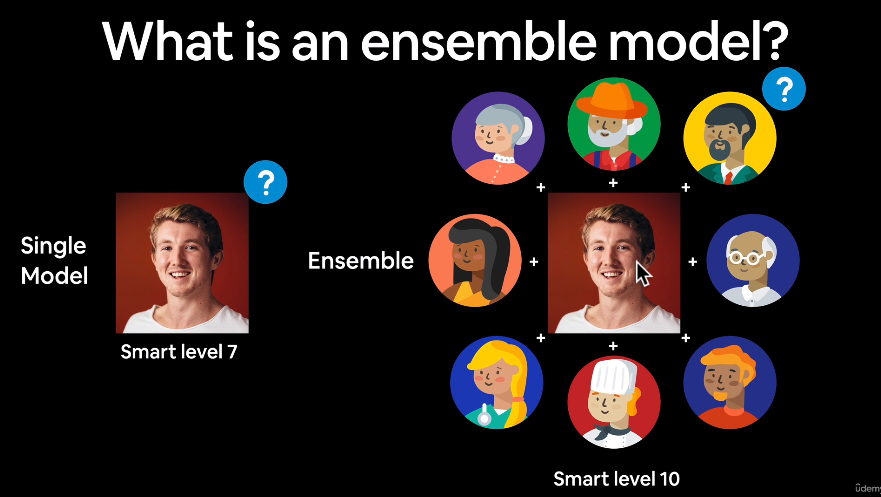

**section 3.4 in the paper**

##Constructing and fitting different esemble models(using different loss functions)

In [ ]:
def get_ensemble_models(
    train_data = train_dataset,
    test_data = test_dataset,
    num_it = 10,
    n_epochs = 1000,
    loss_fns = ["mae", "mse", "mape"]):
  """
  returns a list of num_it models each trained mae, mse, mape
  ex: if num_it = 10 then we return 30 models .
  """

#make empty list of trained ensemble models
  ensemble_models = []
  for i in range(num_it):
    for loss_function in loss_fns:
      print(f"optimizing model by reducing: {loss_function} for {n_epochs} epochs, model number {i}")

      #create a simple model
      model = tf.keras.Sequential([
          #initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
          layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
          layers.Dense(HORIZON)
      ])

      model.compile(loss = loss_function),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["mae", "mse"]

      model.fit(train_data,
                epochs = n_epochs,
                verbose = 0,
                validation_data = test_data,
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                        monitor = "val_loss",
                        patience = 200,
                        restore_best_weights = True
                    ),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", patience = 100, verbose = 1)
                ]

                )
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time

ensemble_models = get_ensemble_models(
    num_it = 5,
    n_epochs = 1000
)

optimizing model by reducing: mae for 1000 epochs, model number 0

Epoch 224: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 536: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
optimizing model by reducing: mse for 1000 epochs, model number 0

Epoch 106: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 219: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 490: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 590: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
optimizing model by reducing: mape for 1000 epochs, model number 0
optimizing model by reducing: mae for 1000 epochs, model number 1

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 207: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
optimizing model by reducing: mse for 1000 epochs, model number 1

Epoch 102: ReduceLROnPlateau

In [ ]:
len(ensemble_models), ensemble_models

(15,
  <keras.engine.sequential.Sequential at 0x7ceb3b664730>])

##making function for predictions

In [ ]:
def make_ensemble_preds(models, data):
  ensemble_preds = []

  for i in models:
    preds = i.predict(data)
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

##making predictions on test_dataset

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds.shape, ensemble_preds[:10]

1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 56ms/step


(TensorShape([15, 556]),
 <tf.Tensor: shape=(10, 556), dtype=float32, numpy=
 array([[ 8784.201 ,  8818.843 ,  9031.959 , ..., 50094.29  , 47993.258 ,
         45263.223 ],
        [ 8767.3545,  8697.088 ,  9074.816 , ..., 50453.918 , 48913.05  ,
         46084.406 ],
        [ 9134.747 ,  9083.501 ,  9405.179 , ..., 52101.97  , 50614.055 ,
         48477.39  ],
        ...,
        [ 8738.054 ,  8774.723 ,  9070.965 , ..., 50459.016 , 48307.645 ,
         46267.805 ],
        [ 8812.993 ,  8818.955 ,  9002.177 , ..., 49803.203 , 47824.977 ,
         45917.082 ],
        [ 8987.409 ,  8863.6045,  8953.196 , ..., 50081.855 , 48826.96  ,
         46959.453 ]], dtype=float32)>)

In [ ]:
ensemble_preds.shape, ensemble_preds[:3]

(TensorShape([15, 556]),
 <tf.Tensor: shape=(3, 556), dtype=float32, numpy=
 array([[ 8784.201 ,  8818.843 ,  9031.959 , ..., 50094.29  , 47993.258 ,
         45263.223 ],
        [ 8767.3545,  8697.088 ,  9074.816 , ..., 50453.918 , 48913.05  ,
         46084.406 ],
        [ 9134.747 ,  9083.501 ,  9405.179 , ..., 52101.97  , 50614.055 ,
         48477.39  ]], dtype=float32)>)

In [ ]:
ensemble_mean_preds = tf.reduce_mean(ensemble_preds, axis = 0)
ensemble_mean_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8805.813, 8769.327, 9015.202, 8741.921, 8737.329, 8704.689,
       8649.928, 8479.295, 8443.33 , 8495.686], dtype=float32)>

In [ ]:
ensemble_median_preds = np.median(ensemble_preds, axis = 0)
ensemble_median_preds[:10]

array([8787.712, 8769.969, 9042.322, 8739.733, 8764.028, 8725.066,
       8640.547, 8494.054, 8462.766, 8503.872], dtype=float32)

In [ ]:
ensemble_mean_res = evaluate_preds(y_test, ensemble_mean_preds)
ensemble_mean_res

{'mae': 569.2634,
 'mse': 1154540.0,
 'rmse': 1074.4952,
 'mape': 2.5816288,
 'mase': 0.028298019}

In [ ]:
ensemble_median_res = evaluate_preds(y_test, ensemble_median_preds)
ensemble_median_res

{'mae': 564.9757,
 'mse': 1139512.9,
 'rmse': 1067.4796,
 'mape': 2.5692437,
 'mase': 0.028084876}

In [ ]:
model_1_res

{'mae': 567.0816,
 'mse': 1171848.5,
 'rmse': 1082.5195,
 'mape': 2.5444036,
 'mase': 0.028189559}

##plotting model prediction estimates (uncertainity estimates) of our ensemble models

so far we made point predictions

eg : Horizon = 1, so our model predicts single price for tomorrows date

It would be helpful to get a range in which the values may range which has more chances to be right than the point prediction

This is why we used he_normal for kernel_initializer as we want the weights to be initialized as normal distribution

This is all assuming our data is normally distributed

**Plotting the prediction intervals (uncertainty estimates) of our ensemble**

Right now all of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of `WINDOW_SIZE=7` values, the model will predict `HORIZION=1`.

But what might be more helpful than a single value?

Perhaps a range of values?

For example, if a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000 and 52,000USD? (note: "$" has been omitted from the previous sentence due to formatting issues)

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

You'd know that although the model is predicting 50,000USD (a **point prediction**, or single value in time), the value could actually be within the range 48,000USD to 52,000USD (of course, the value could also be *outside* of this range as well, but we'll get to that later).

These kind of prediction ranges are called **prediction intervals** or **uncertainty estimates**. And they're often as important as the forecast itself.

Why?

Because **point predictions** are almost always going to be wrong. So having a range of values can help with decision making.

> üìñ **Resource(s):**
> * The steps we're about to take have been inspired by the Machine Learning Mastery blog post [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
> * For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

![example of Uber's prediction intervals for daily completed trips in San Francisco](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-intervals-from-ubers-uncertainty-measures.png)
*Example of how uncertainty estimates and predictions intervals can give an understanding of where point predictions (a single number) may not include all of useful information you'd like to know. For example, your model's point prediction for Uber trips on New Years Eve might be 100 (a made up number) but really, the prediction intervals are between 55 and 153 (both made up for the example). In this case, preparing 100 rides might end up being 53 short (it could even be more, like the point prediction, the prediction intervals are also estimates). The image comes from Uber's [blog post on uncertainty estimation in neural networks](https://eng.uber.com/neural-networks-uncertainty-estimation/).*

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


##Making function to get the intervals (upper and lower bounds)

In [ ]:
def get_interval(preds):
  """
  returns upper and lower bounds of interval which covers 95 pecent of the normal distribution observations
  """
  #getting mean and standard deviation of the preds
  mean = tf.reduce_mean(preds, axis = 0)
  standard_deviation = tf.math.reduce_std(preds, axis = 0)

  #calculating the interval by multiplying std with 1.96
  interval = 1.96 * standard_deviation

  #make upper and lower bound and return them
  lower , upper = mean - interval, mean + interval

  return lower, upper

In [ ]:
lower, upper = get_interval(ensemble_preds)

lower.shape, upper.shape

(TensorShape([556]), TensorShape([556]))

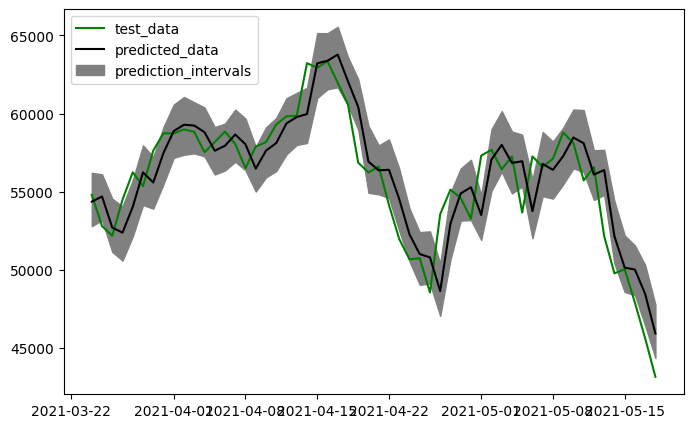

In [ ]:
offset = 500

plt.figure(figsize = (8, 5))

plt.plot(x_test.index[offset:], y_test[offset:], "g", label = "test_data")
plt.plot(x_test.index[offset:], ensemble_median_preds[offset:], "k-", label = "predicted_data")
plt.fill_between(
    x_test.index[offset:],
    (lower)[offset:],
    (upper)[offset:],
    label = "prediction_intervals",
    color = "gray"
)

plt.legend(loc = "upper left", fontsize = 10)

##NOTE:
We noticed that all our preds are lagging behind the original data. This might indicate few things such as our model is overfitting or maybe the data is unpredictable.
from the book :
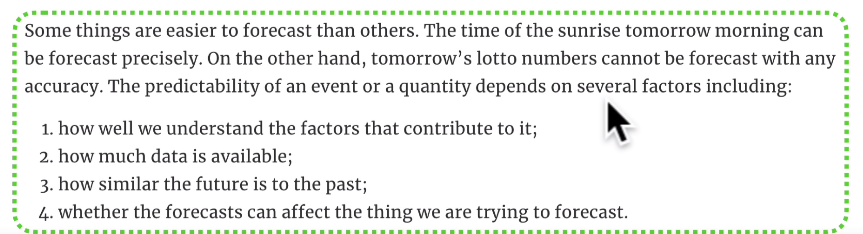

#Model 9:Train a model on full historical data to make predictions into the future.

Until now our models predicted only on the test data i.e pseudo future.

Now we'll build a model capable of predicting into the future.

We will train our model on the whole dataset instead of dividing it into train and test dataset

##Preparing the data

In [ ]:
windowed_block_df.head()

price block_reward    price 1    price 2    price 3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   

              price 4  price 5  price 6  price 7  
Date                                              
2013-10-01        NaN      NaN      NaN      NaN  
2013-10-02        NaN      NaN      NaN      NaN  
2013-10-03        NaN      NaN      NaN      NaN  
2013-10-04        NaN      NaN      NaN      NaN  
2013-10-05  123.65499      NaN      NaN      NaN

In [ ]:
x_all = windowed_block_df.dropna().drop(["price", "block_reward"], axis = 1).to_numpy()
y_all = windowed_block_df.dropna()["price"].to_numpy()

x_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
features_all = tf.data.Dataset.from_tensor_slices(x_all)
labels_all = tf.data.Dataset.from_tensor_slices(y_all)

full_dataset = tf.data.Dataset.zip((features_all, labels_all))

BATCH_SIZE = 1024
full_dataset = full_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
full_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

##building and training our model on full dataset

In [ ]:
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "future_pred_model")

model_9.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
)

model_9.fit(
    full_dataset,
    epochs = 100,
    verbose = 0
)

##making predictions into the future

---

We need to train our model everytime we want to generate a new forecast as it is a timeseries problem.



In [ ]:
WINDOW_SIZE

7

In [ ]:
INTO_FUTURE = 14

def make_future_preds(values, model, into_future, window_size = WINDOW_SIZE) -> list:


  future_forecast = []
  last_window = values[-window_size:]

  for _ in range(into_future):

    future_pred = model.predict(tf.expand_dims(last_window, axis = 0))
    print(f"predicting on: {last_window} -> prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())

    last_window = np.append(last_window, future_forecast)[-window_size:]

  return future_forecast

In [ ]:
future_forecast = make_future_preds(
    y_all,
    model_9,
    INTO_FUTURE
)

1/1 [==============================] - 0s 51ms/step
predicting on: [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> prediction: 55295.6640625

1/1 [==============================] - 0s 19ms/step
predicting on: [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55295.6640625 ] -> prediction: 51624.4765625

1/1 [==============================] - 0s 17ms/step
predicting on: [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55295.6640625  55295.6640625  51624.4765625 ] -> prediction: 47579.3984375

1/1 [==============================] - 0s 17ms/step
predicting on: [43144.47129086 55295.6640625  55295.6640625  51624.4765625
 55295.6640625  51624.4765625  47579.3984375 ] -> prediction: 48847.3984375

1/1 [==============================] - 0s 17ms/step
predicting on: [55295.6640625 51624.4765625 47579.3984375 55295.6640625 51624.4765625
 47579.3984375 48847.3984375] -> prediction

In [ ]:
future_forecast

[55295.664,
 51624.477,
 47579.4,
 48847.4,
 53663.734,
 49059.086,
 53947.35,
 53276.363,
 49329.586,
 48362.07,
 50801.27,
 52675.586,
 51264.14,
 53036.266]

##get_future_dates function

In [ ]:
def get_future_dates(start_date, into_future, offset = 1):

  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype = "datetime64[D]")


In [ ]:
last_timestamp = prices_df.index[-1]
last_timestamp

Timestamp('2021-05-18 00:00:00')

In [ ]:
future_dates = get_future_dates(last_timestamp, INTO_FUTURE)
len(future_dates), future_dates

(14,
 array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
        '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
        '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
        '2021-05-31', '2021-06-01'], dtype='datetime64[D]'))

In [ ]:
prices[-1]

43144.4712908603

In [ ]:
prices_df.iloc[-1]

price    43144.471291
Name: 2021-05-18 00:00:00, dtype: float64

In [ ]:
future_dates = np.insert(future_dates, 0, last_timestamp)
future_forecast = np.insert(future_forecast, 0, prices[-1])
future_dates, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55295.664, 51624.477, 47579.4  , 48847.4  , 53663.734,
        49059.086, 53947.35 , 53276.363, 49329.586, 48362.07 , 50801.27 ,
        52675.586, 51264.14 , 53036.266], dtype=float32))

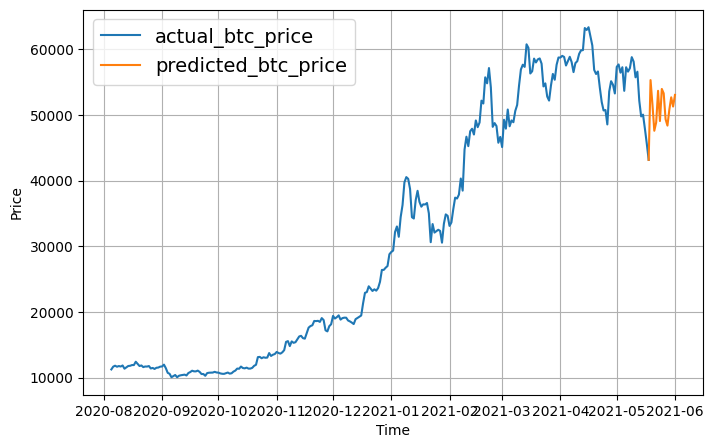

In [ ]:
plt.figure(figsize = (8, 5))

plot_timeseries(prices_df.index, prices, start = 2500, format="-", label = "actual_btc_price")
plot_timeseries(future_dates, future_forecast, format = "-", label = "predicted_btc_price")

#Turkey problem and model 10

In [ ]:
turkey_prob = prices.copy()
turkey_prob[-1] = turkey_prob[-1] / 100
turkey_prob[-10:], prices[-10:]

(array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361,   431.44471291]),
 array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]))

In [ ]:
turkey_timesteps = np.array(prices_df.index)
turkey_timesteps[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

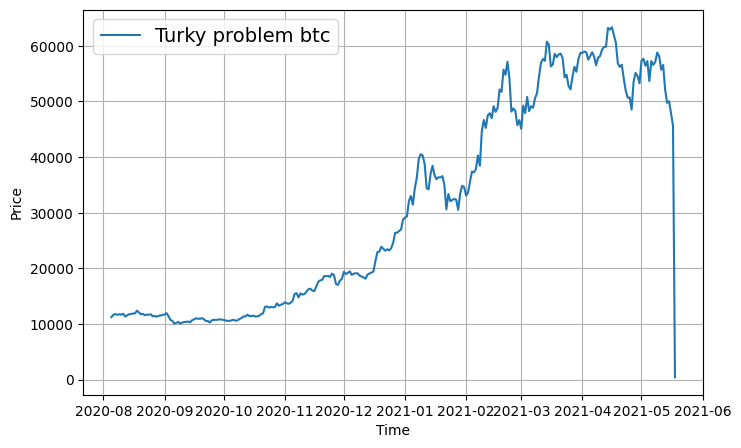

In [ ]:
plt.figure(figsize = (8, 5))

plot_timeseries(
    turkey_timesteps,
    turkey_prob,
    start = 2500,
    format = "-",
    label = "Turky problem btc"
)

##preparing the dataset

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

In [ ]:
turkey_window, turkey_label = make_windows(turkey_prob, WINDOW_SIZE, HORIZON)
x_train, x_test, y_train, y_test = window_horizon_train_test_split(turkey_window, turkey_label, 0.2)
len(x_train), len(x_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

##making the model

In [ ]:
from tensorflow.keras import layers

tf.random.set_seed(42)

model_10_dense = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear")
], name = "model_10_dense")

model_10_dense.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

model_10_dense.fit(
    x_train, y_train,
    epochs = 100,
    batch_size = 128,
    validation_data = (x_test, y_test),
    verbose = 1,
    callbacks = [create_model_checkpoint(model_name = model_10_dense.name)]
)

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 3040.9089 - mae: 3040.9089 - mse: 23265720.0000 

18/18 [==============================] - 2s 46ms/step - loss: 2312.2251 - mae: 2312.2251 - mse: 15452573.0000 - val_loss: 2326.7681 - val_mae: 2326.7681 - val_mse: 12576419.0000
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 379.8771 - mae: 379.8771 - mse: 562878.0000

18/18 [==============================] - 1s 32ms/step - loss: 379.8771 - mae: 379.8771 - mse: 562878.0000 - val_loss: 1758.5435 - val_mae: 1758.5435 - val_mse: 7816345.0000
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 259.8304 - mae: 259.8304 - mse: 315619.9688

18/18 [==============================] - 1s 34ms/step - loss: 253.8525 - mae: 253.8525 - mse: 306459.8750 - val_loss: 1164.0668 - val_mae: 1164.0668 - val_mse: 4412524.5000
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 206.8650 - mae: 206.8650 - mse: 218869.7188

18/18 [==============================] - 1s 33ms/step - loss: 206.8650 - mae: 206.8650 - mse: 218869.7188 - val_loss: 1113.1456 - val_mae: 1113.1456 - val_mse: 4094876.5000
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 202.9439 - mae: 202.9439 - mse: 214486.5156 - val_loss: 1134.0979 - val_mae: 1134.0979 - val_mse: 4046238.5000
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 192.7487 - mae: 192.7487 - mse: 184353.6094

18/18 [==============================] - 1s 33ms/step - loss: 194.3290 - mae: 194.3290 - mse: 195082.6406 - val_loss: 1059.9312 - val_mae: 1059.9312 - val_mse: 3793047.5000
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 187.6120 - mae: 187.6120 - mse: 183776.6094 - val_loss: 1071.7277 - val_mae: 1071.7277 - val_mse: 3606545.5000
Epoch 8/100
16/18 [=========================>....] - ETA: 0s - loss: 183.3417 - mae: 183.3417 - mse: 177704.1406

18/18 [==============================] - 1s 33ms/step - loss: 184.0739 - mae: 184.0739 - mse: 175675.5625 - val_loss: 1004.3513 - val_mae: 1004.3513 - val_mse: 3331821.0000
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 178.1150 - mae: 178.1150 - mse: 168919.8125

18/18 [==============================] - 1s 32ms/step - loss: 178.1150 - mae: 178.1150 - mse: 168919.8125 - val_loss: 1002.3746 - val_mae: 1002.3746 - val_mse: 3213482.7500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 194.4038 - mae: 194.4038 - mse: 263999.4375

18/18 [==============================] - 1s 33ms/step - loss: 174.1444 - mae: 174.1444 - mse: 160885.5625 - val_loss: 957.4459 - val_mae: 957.4459 - val_mse: 3002366.7500
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 168.1086 - mae: 168.1086 - mse: 151739.5938

18/18 [==============================] - 1s 48ms/step - loss: 167.9185 - mae: 167.9185 - mse: 150354.2031 - val_loss: 918.6369 - val_mae: 918.6369 - val_mse: 2846007.0000
Epoch 12/100
18/18 [==============================] - 0s 9ms/step - loss: 164.5200 - mae: 164.5200 - mse: 142801.0625 - val_loss: 1060.4290 - val_mae: 1060.4290 - val_mse: 3152854.0000
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 163.2611 - mae: 163.2611 - mse: 144144.6875

18/18 [==============================] - 1s 47ms/step - loss: 164.0216 - mae: 164.0216 - mse: 144197.9531 - val_loss: 873.1570 - val_mae: 873.1570 - val_mse: 2525980.2500
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 154.4570 - mae: 154.4570 - mse: 130884.8125

18/18 [==============================] - 1s 42ms/step - loss: 154.9722 - mae: 154.9722 - mse: 129575.2500 - val_loss: 856.9379 - val_mae: 856.9379 - val_mse: 2394468.5000
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 157.8188 - mae: 157.8188 - mse: 130782.5469 - val_loss: 944.4019 - val_mae: 944.4020 - val_mse: 2563420.0000
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 149.2401 - mae: 149.2401 - mse: 119609.5000

18/18 [==============================] - 1s 32ms/step - loss: 149.2401 - mae: 149.2401 - mse: 119609.5000 - val_loss: 813.1523 - val_mae: 813.1523 - val_mse: 2147817.2500
Epoch 17/100
15/18 [========================>.....] - ETA: 0s - loss: 141.0218 - mae: 141.0218 - mse: 108388.6484

18/18 [==============================] - 1s 32ms/step - loss: 142.5162 - mae: 142.5162 - mse: 111738.6797 - val_loss: 812.6836 - val_mae: 812.6836 - val_mse: 2081616.3750
Epoch 18/100
18/18 [==============================] - ETA: 0s - loss: 138.0299 - mae: 138.0299 - mse: 106359.2266

18/18 [==============================] - 1s 33ms/step - loss: 138.0299 - mae: 138.0299 - mse: 106359.2266 - val_loss: 801.2905 - val_mae: 801.2905 - val_mse: 2003770.0000
Epoch 19/100
18/18 [==============================] - ETA: 0s - loss: 134.1357 - mae: 134.1357 - mse: 101104.9844

18/18 [==============================] - 1s 33ms/step - loss: 134.1357 - mae: 134.1357 - mse: 101104.9844 - val_loss: 772.4272 - val_mae: 772.4272 - val_mse: 1887524.6250
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 141.0034 - mae: 141.0034 - mse: 118685.6875

18/18 [==============================] - 1s 31ms/step - loss: 137.3682 - mae: 137.3682 - mse: 104659.6406 - val_loss: 718.2200 - val_mae: 718.2200 - val_mse: 1760267.7500
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 133.5940 - mae: 133.5940 - mse: 100013.7031 - val_loss: 725.5025 - val_mae: 725.5025 - val_mse: 1703064.3750
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 128.2209 - mae: 128.2209 - mse: 95048.1172 

18/18 [==============================] - 1s 34ms/step - loss: 126.6394 - mae: 126.6394 - mse: 91687.9609 - val_loss: 698.7374 - val_mae: 698.7374 - val_mse: 1618696.6250
Epoch 23/100
18/18 [==============================] - ETA: 0s - loss: 125.9481 - mae: 125.9481 - mse: 89676.5938

18/18 [==============================] - 1s 31ms/step - loss: 125.9481 - mae: 125.9481 - mse: 89676.5938 - val_loss: 693.5831 - val_mae: 693.5831 - val_mse: 1581898.6250
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 127.1881 - mae: 127.1881 - mse: 89822.3438

18/18 [==============================] - 1s 34ms/step - loss: 127.1881 - mae: 127.1881 - mse: 89822.3438 - val_loss: 663.8925 - val_mae: 663.8925 - val_mse: 1510566.0000
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 129.7227 - mae: 129.7227 - mse: 89570.7578

18/18 [==============================] - 1s 31ms/step - loss: 129.7227 - mae: 129.7227 - mse: 89570.7578 - val_loss: 652.3424 - val_mae: 652.3424 - val_mse: 1477918.8750
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 123.3326 - mae: 123.3326 - mse: 85425.5156 - val_loss: 667.6537 - val_mae: 667.6537 - val_mse: 1524035.2500
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 122.1926 - mae: 122.1926 - mse: 82199.2656 

18/18 [==============================] - 1s 32ms/step - loss: 122.1995 - mae: 122.1995 - mse: 84878.9766 - val_loss: 636.4848 - val_mae: 636.4848 - val_mse: 1414541.1250
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 117.4990 - mae: 117.4990 - mse: 79972.6484

18/18 [==============================] - 1s 62ms/step - loss: 117.4990 - mae: 117.4990 - mse: 79972.6484 - val_loss: 629.6348 - val_mae: 629.6348 - val_mse: 1387509.6250
Epoch 29/100
17/18 [===========================>..] - ETA: 0s - loss: 113.3628 - mae: 113.3628 - mse: 75728.9062

18/18 [==============================] - 1s 34ms/step - loss: 115.7003 - mae: 115.7003 - mse: 79297.9844 - val_loss: 622.8088 - val_mae: 622.8088 - val_mse: 1364547.3750
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 118.5627 - mae: 118.5627 - mse: 80038.9453 - val_loss: 625.9536 - val_mae: 625.9536 - val_mse: 1373526.7500
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 114.3940 - mae: 114.3940 - mse: 76760.6953 - val_loss: 630.7897 - val_mae: 630.7897 - val_mse: 1358421.5000
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 114.8646 - mae: 114.8646 - mse: 79330.4688

18/18 [==============================] - 1s 33ms/step - loss: 114.8646 - mae: 114.8646 - mse: 79330.4688 - val_loss: 612.0071 - val_mae: 612.0071 - val_mse: 1320342.6250
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 114.3500 - mae: 114.3500 - mse: 77477.7969 - val_loss: 648.9820 - val_mae: 648.9820 - val_mse: 1385486.6250
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 115.1287 - mae: 115.1287 - mse: 79230.9141 

18/18 [==============================] - 1s 34ms/step - loss: 115.8938 - mae: 115.8938 - mse: 79418.5859 - val_loss: 603.6351 - val_mae: 603.6351 - val_mse: 1298731.5000
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4103 - mae: 112.4103 - mse: 76450.7969 - val_loss: 619.0635 - val_mae: 619.0635 - val_mse: 1337279.5000
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 117.1685 - mae: 117.1685 - mse: 79171.9375 

18/18 [==============================] - 1s 35ms/step - loss: 116.9765 - mae: 116.9765 - mse: 78341.6797 - val_loss: 598.3187 - val_mae: 598.3187 - val_mse: 1281343.7500
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 115.5822 - mae: 115.5822 - mse: 79283.3125 - val_loss: 605.8241 - val_mae: 605.8241 - val_mse: 1301029.0000
Epoch 38/100
18/18 [==============================] - 0s 9ms/step - loss: 114.0997 - mae: 114.0997 - mse: 76935.3203 - val_loss: 602.9286 - val_mae: 602.9286 - val_mse: 1292004.0000
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 113.5210 - mae: 113.5210 - mse: 80027.3359 

18/18 [==============================] - 1s 50ms/step - loss: 111.9235 - mae: 111.9235 - mse: 75366.5078 - val_loss: 593.1629 - val_mae: 593.1629 - val_mse: 1264793.8750
Epoch 40/100
15/18 [========================>.....] - ETA: 0s - loss: 112.2319 - mae: 112.2319 - mse: 78395.3359 

18/18 [==============================] - 1s 47ms/step - loss: 111.5055 - mae: 111.5055 - mse: 74880.1484 - val_loss: 593.1438 - val_mae: 593.1438 - val_mse: 1264274.0000
Epoch 41/100
18/18 [==============================] - 0s 8ms/step - loss: 111.5364 - mae: 111.5364 - mse: 75050.1953 - val_loss: 649.5626 - val_mae: 649.5626 - val_mse: 1395042.5000
Epoch 42/100
12/18 [===================>..........] - ETA: 0s - loss: 115.2536 - mae: 115.2536 - mse: 78192.4297

18/18 [==============================] - 1s 34ms/step - loss: 117.7698 - mae: 117.7698 - mse: 79296.7188 - val_loss: 589.8002 - val_mae: 589.8002 - val_mse: 1249011.3750
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 114.1334 - mae: 114.1334 - mse: 75025.9062 - val_loss: 631.3228 - val_mae: 631.3228 - val_mse: 1344257.8750
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 116.7257 - mae: 116.7257 - mse: 77228.6953

18/18 [==============================] - 1s 33ms/step - loss: 116.7257 - mae: 116.7257 - mse: 77228.6953 - val_loss: 589.5865 - val_mae: 589.5865 - val_mse: 1250655.5000
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 114.9335 - mae: 114.9335 - mse: 78415.1875 - val_loss: 611.6160 - val_mae: 611.6160 - val_mse: 1279173.7500
Epoch 46/100
17/18 [===========================>..] - ETA: 0s - loss: 113.2332 - mae: 113.2332 - mse: 74739.4531

18/18 [==============================] - 1s 32ms/step - loss: 113.9573 - mae: 113.9573 - mse: 75507.2578 - val_loss: 585.5840 - val_mae: 585.5840 - val_mse: 1237912.1250
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 114.0223 - mae: 114.0223 - mse: 77253.3203 - val_loss: 713.1079 - val_mae: 713.1079 - val_mse: 1519737.5000
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0225 - mae: 113.0225 - mse: 74008.6406 - val_loss: 614.5648 - val_mae: 614.5648 - val_mse: 1280067.6250
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 112.9856 - mae: 112.9856 - mse: 74989.2109 - val_loss: 586.5557 - val_mae: 586.5557 - val_mse: 1230691.0000
Epoch 50/100
17/18 [===========================>..] - ETA: 0s - loss: 113.5261 - mae: 113.5261 - mse: 75107.6875 

18/18 [==============================] - 1s 32ms/step - loss: 113.7111 - mae: 113.7111 - mse: 75172.9766 - val_loss: 581.4231 - val_mae: 581.4231 - val_mse: 1225048.8750
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 110.4378 - mae: 110.4378 - mse: 73339.0156 - val_loss: 614.8326 - val_mae: 614.8326 - val_mse: 1278513.8750
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8891 - mae: 112.8891 - mse: 76160.8281 - val_loss: 588.1782 - val_mae: 588.1782 - val_mse: 1238132.7500
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0437 - mae: 115.0437 - mse: 76585.5938 - val_loss: 669.3484 - val_mae: 669.3484 - val_mse: 1398488.8750
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 122.5652 - mae: 122.5652 - mse: 80860.2188 - val_loss: 681.7186 - val_mae: 681.7186 - val_mse: 1427355.8750
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 114.2364 - mae: 114.2364 - m

18/18 [==============================] - 1s 32ms/step - loss: 118.7365 - mae: 118.7365 - mse: 75695.7500 - val_loss: 576.2352 - val_mae: 576.2352 - val_mse: 1208153.1250
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7434 - mae: 109.7434 - mse: 72705.6641 - val_loss: 579.8442 - val_mae: 579.8442 - val_mse: 1215301.7500
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 92.6245 - mae: 92.6245 - mse: 38617.7188

18/18 [==============================] - 1s 32ms/step - loss: 108.3501 - mae: 108.3501 - mse: 71228.3672 - val_loss: 575.7210 - val_mae: 575.7210 - val_mse: 1207767.5000
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1120 - mae: 109.1120 - mse: 72481.5547 - val_loss: 593.2560 - val_mae: 593.2560 - val_mse: 1228430.0000
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 109.4502 - mae: 109.4502 - mse: 72077.6953 - val_loss: 588.4852 - val_mae: 588.4852 - val_mse: 1227294.0000
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 110.1133 - mae: 110.1133 - mse: 73170.5078 - val_loss: 629.1746 - val_mae: 629.1746 - val_mse: 1297746.6250
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9211 - mae: 110.9211 - mse: 72812.1016 - val_loss: 609.4611 - val_mae: 609.4611 - val_mse: 1257098.1250
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 109.5005 - mae: 109.5005 - m

18/18 [==============================] - 1s 33ms/step - loss: 124.0351 - mae: 124.0351 - mse: 81941.4062 - val_loss: 575.1677 - val_mae: 575.1677 - val_mse: 1196202.1250
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3169 - mae: 113.3169 - mse: 72794.3750 - val_loss: 597.9808 - val_mae: 597.9808 - val_mse: 1232010.8750
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 108.8147 - mae: 108.8147 - mse: 72455.2969 - val_loss: 591.6303 - val_mae: 591.6303 - val_mse: 1224720.8750
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4979 - mae: 116.4979 - mse: 76038.6797 - val_loss: 722.3588 - val_mae: 722.3588 - val_mse: 1568253.5000
Epoch 74/100
18/18 [==============================] - ETA: 0s - loss: 110.0507 - mae: 110.0507 - mse: 73061.6250 

18/18 [==============================] - 1s 32ms/step - loss: 110.0507 - mae: 110.0507 - mse: 73061.6250 - val_loss: 573.6445 - val_mae: 573.6445 - val_mse: 1192775.2500
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3464 - mae: 110.3464 - mse: 72088.9766 - val_loss: 633.0200 - val_mae: 633.0200 - val_mse: 1301915.6250
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3139 - mae: 112.3139 - mse: 73849.6094 - val_loss: 575.4825 - val_mae: 575.4825 - val_mse: 1192191.2500
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3598 - mae: 108.3598 - mse: 70505.0547 - val_loss: 598.7852 - val_mae: 598.7852 - val_mse: 1236284.6250
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3809 - mae: 108.3809 - mse: 70483.6562 - val_loss: 581.0668 - val_mae: 581.0668 - val_mse: 1202998.6250
Epoch 79/100
 1/18 [>.............................] - ETA: 0s - loss: 107.0399 - mae: 107.0399 - mse: 

18/18 [==============================] - 1s 31ms/step - loss: 109.8786 - mae: 109.8786 - mse: 74455.0000 - val_loss: 571.9971 - val_mae: 571.9971 - val_mse: 1185167.6250
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 107.2766 - mae: 107.2766 - mse: 71006.6484 - val_loss: 582.6693 - val_mae: 582.6693 - val_mse: 1197141.6250
Epoch 81/100
17/18 [===========================>..] - ETA: 0s - loss: 107.2451 - mae: 107.2451 - mse: 70793.9062

18/18 [==============================] - 1s 32ms/step - loss: 107.5960 - mae: 107.5960 - mse: 71046.5234 - val_loss: 567.7615 - val_mae: 567.7615 - val_mse: 1177804.8750
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 115.8793 - mae: 115.8793 - mse: 76944.9688 - val_loss: 570.4429 - val_mae: 570.4429 - val_mse: 1182514.2500
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1091 - mae: 113.1091 - mse: 74445.2891 - val_loss: 650.1583 - val_mae: 650.1583 - val_mse: 1352756.8750
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1409 - mae: 114.1409 - mse: 72714.0859 - val_loss: 605.4470 - val_mae: 605.4470 - val_mse: 1247745.2500
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0417 - mae: 108.0417 - mse: 71290.1562 - val_loss: 586.3371 - val_mae: 586.3371 - val_mse: 1199578.6250
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 108.6664 - mae: 108.6664 - m

18/18 [==============================] - 1s 47ms/step - loss: 106.5654 - mae: 106.5654 - mse: 68277.0078 - val_loss: 564.9384 - val_mae: 564.9384 - val_mse: 1163266.8750
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 108.1168 - mae: 108.1168 - mse: 70048.1016 - val_loss: 622.5037 - val_mae: 622.5037 - val_mse: 1281160.7500
Epoch 97/100
18/18 [==============================] - 0s 8ms/step - loss: 109.6457 - mae: 109.6457 - mse: 72272.8750 - val_loss: 607.2720 - val_mae: 607.2720 - val_mse: 1239960.5000
Epoch 98/100
18/18 [==============================] - 0s 8ms/step - loss: 108.6465 - mae: 108.6465 - mse: 71167.9531 - val_loss: 590.3990 - val_mae: 590.3990 - val_mse: 1215180.1250
Epoch 99/100
18/18 [==============================] - 0s 8ms/step - loss: 108.5454 - mae: 108.5454 - mse: 71544.7031 - val_loss: 573.6125 - val_mae: 573.6125 - val_mse: 1180129.0000
Epoch 100/100
18/18 [==============================] - 0s 8ms/step - loss: 115.2850 - mae: 115.2850 - 

##evaluating

In [ ]:
y_test[-1]

array([43144.47129086])

In [ ]:
model_10 = tf.keras.models.load_model("/content/Model_Experiments/model_10_dense")
model_10.evaluate(x_test, y_test)

18/18 [==============================] - 0s 6ms/step - loss: 564.9384 - mae: 564.9384 - mse: 1163266.8750


[564.9384155273438, 564.9384155273438, 1163266.875]

In [ ]:
turkey_preds = make_preds(model_10, x_test)
turkey_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57187.59 , 58668.137, 58308.324, 56412.55 , 56235.258, 52904.316,
       50054.29 , 49596.168, 48338.918, 46026.504], dtype=float32)>

In [ ]:
model_10_res = evaluate_preds(
    y_test,
    turkey_preds
)
model_10_res

{'mae': 17147.266,
 'mse': 615049400.0,
 'rmse': 23729.271,
 'mape': 113.35662,
 'mase': 0.85238856}

#plotting preds and target labels

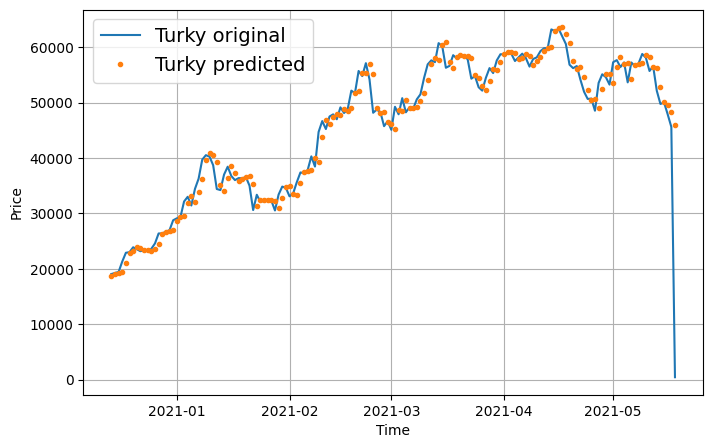

In [ ]:
plt.figure(figsize = (8, 5))
offset = 400

plot_timeseries(
    turkey_timesteps[-len(x_test):],
    turkey_prob[-len(x_test):],
    start = offset,
    format = "-",
    label = "Turky original"
)

plot_timeseries(
    turkey_timesteps[-len(x_test):],
    turkey_preds,
    start = offset,
    label = "Turky predicted"
)

#visualizing all models mae

In [ ]:
import pandas as pd

all = pd.DataFrame({
    "dense_7_1": model_1_res,
    "dense_30_1": model_2_res,
    "dense_30_7":model_3_res,
    "conv_1d_7_1": model_4_res,
    "LSTM_7_1": model_5_results,
    "mv_7_1": model_6_res,
    "ensemble_7_1": ensemble_median_res,
    "turkey_7_1": model_10_res

})

all = all.transpose()
all

mae           mse          rmse        mape      mase
dense_7_1       567.081604  1.171848e+06   1082.519531    2.544404  0.028190
dense_30_1      591.462097  1.231148e+06   1109.570923    2.636919  0.029282
dense_30_7     1250.745117  5.388820e+06   1440.255615    5.548986  0.062497
conv_1d_7_1     564.807922  1.159276e+06   1076.697021    2.510585  0.028077
LSTM_7_1        567.165344  1.174807e+06   1083.885010    2.561726  0.028194
mv_7_1        17145.710938  6.148646e+08  23717.966797  113.322517  0.852311
ensemble_7_1    564.975708  1.139513e+06   1067.479614    2.569244  0.028085
turkey_7_1    17147.265625  6.150494e+08  23729.271484  113.356621  0.852389

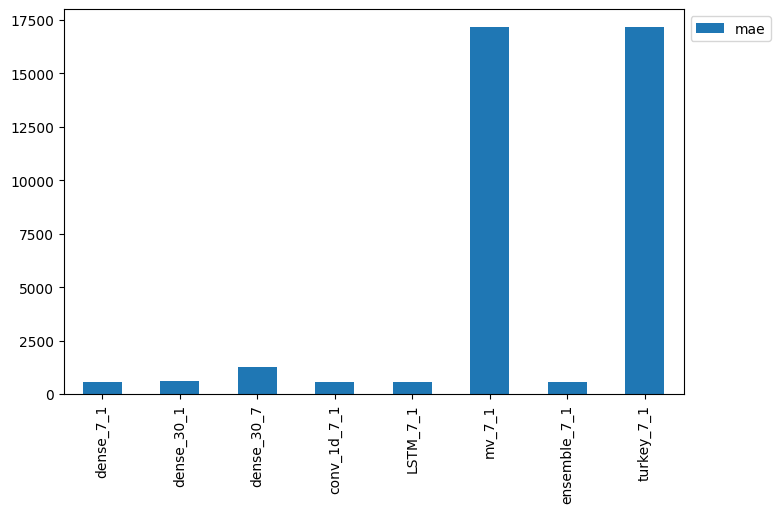

In [ ]:
all["mae"].plot(kind = "bar", figsize = (8,5)).legend(bbox_to_anchor = (1.0, 1.0))